In [ ]:
!pip install yfinance
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
#from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import os

## 1) extracción

In [ ]:
def get_sp500_tickets():
  url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
  data = requests.get(url)
  sp500_tickets = pd.read_html(data.text)
  d = sp500_tickets[0]
  subset = d.select_dtypes(include='object').columns.tolist()
  d[subset] = d[subset].astype('string')
  return d

In [ ]:
d = get_sp500_tickets()

<ipython-input-6-23fc4aac8e00>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500_tickets = pd.read_html(data.text)


In [ ]:
d

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [ ]:
subset = d.select_dtypes(include='object').columns.tolist()
d[subset] = d[subset].astype('string')

In [ ]:
d.dtypes

,0
Symbol,string[python]
Security,string[python]
GICS Sector,string[python]
GICS Sub-Industry,string[python]
Headquarters Location,string[python]
Date added,string[python]
CIK,int64
Founded,string[python]


In [ ]:
d.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    string
 1   Security               503 non-null    string
 2   GICS Sector            503 non-null    string
 3   GICS Sub-Industry      503 non-null    string
 4   Headquarters Location  503 non-null    string
 5   Date added             503 non-null    string
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    string
dtypes: int64(1), string(7)
memory usage: 31.6 KB


In [ ]:
#def download_sp500_history(start="2010-01-01", end="2024-12-31", output_dir="sp500_data"):
output_dir = "sp500_data/de2020-2021"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
def download_sp500_history(start="2010-01-01", end="2024-12-31", output_dir="sp500_data"):
    os.makedirs(output_dir, exist_ok=True)
    ticker_sp500 = "^GSPC"
    data_sp500_download = yf.download(ticker_sp500, start=start, end=end)
    data_sp500_download.to_csv(f"{output_dir}/sp500.csv")


[*********************100%***********************]  1 of 1 completed


In [ ]:

for ticket in d["Symbol"]:
  try:
    data = yf.download(ticket, start="2020-01-01", end="2021-12-31")
  except Exception as e:
    print(f"Error downloading data for {ticket}: {e}")
    continue
  data.to_csv(f"{output_dir}/{ticket}.csv")
  print(f"Downloaded data for {ticket}")



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Downloaded data for MMM


[*********************100%***********************]  1 of 1 completed


Downloaded data for AOS


[*********************100%***********************]  1 of 1 completed


Downloaded data for ABT


[*********************100%***********************]  1 of 1 completed


Downloaded data for ABBV


[*********************100%***********************]  1 of 1 completed


Downloaded data for ACN


[*********************100%***********************]  1 of 1 completed


Downloaded data for ADBE


[*********************100%***********************]  1 of 1 completed


Downloaded data for AMD


[*********************100%***********************]  1 of 1 completed


Downloaded data for AES


[*********************100%***********************]  1 of 1 completed


Downloaded data for AFL


[*********************100%***********************]  1 of 1 completed


Downloaded data for A


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded data for APD


Downloaded data for ABNB


[*********************100%***********************]  1 of 1 completed


Downloaded data for AKAM


[*********************100%***********************]  1 of 1 completed


Downloaded data for ALB


[*********************100%***********************]  1 of 1 completed


Downloaded data for ARE


[*********************100%***********************]  1 of 1 completed


Downloaded data for ALGN


[*********************100%***********************]  1 of 1 completed


Downloaded data for ALLE


[*********************100%***********************]  1 of 1 completed


Downloaded data for LNT


[*********************100%***********************]  1 of 1 completed


Downloaded data for ALL


[*********************100%***********************]  1 of 1 completed


Downloaded data for GOOGL


[*********************100%***********************]  1 of 1 completed


Downloaded data for GOOG


[*********************100%***********************]  1 of 1 completed


Downloaded data for MO


[*********************100%***********************]  1 of 1 completed


Downloaded data for AMZN


[*********************100%***********************]  1 of 1 completed


Downloaded data for AMCR


[*********************100%***********************]  1 of 1 completed


Downloaded data for AEE


[*********************100%***********************]  1 of 1 completed


Downloaded data for AEP


[*********************100%***********************]  1 of 1 completed


Downloaded data for AXP


[*********************100%***********************]  1 of 1 completed


Downloaded data for AIG


[*********************100%***********************]  1 of 1 completed


Downloaded data for AMT


[*********************100%***********************]  1 of 1 completed


Downloaded data for AWK


[*********************100%***********************]  1 of 1 completed


Downloaded data for AMP


[*********************100%***********************]  1 of 1 completed


Downloaded data for AME


[*********************100%***********************]  1 of 1 completed


Downloaded data for AMGN


[*********************100%***********************]  1 of 1 completed


Downloaded data for APH


[*********************100%***********************]  1 of 1 completed


Downloaded data for ADI


[*********************100%***********************]  1 of 1 completed


Downloaded data for ANSS


[*********************100%***********************]  1 of 1 completed


Downloaded data for AON


[*********************100%***********************]  1 of 1 completed


Downloaded data for APA


[*********************100%***********************]  1 of 1 completed


Downloaded data for APO


[*********************100%***********************]  1 of 1 completed


Downloaded data for AAPL


[*********************100%***********************]  1 of 1 completed


Downloaded data for AMAT


[*********************100%***********************]  1 of 1 completed


Downloaded data for APTV


[*********************100%***********************]  1 of 1 completed


Downloaded data for ACGL


[*********************100%***********************]  1 of 1 completed


Downloaded data for ADM


[*********************100%***********************]  1 of 1 completed


Downloaded data for ANET


[*********************100%***********************]  1 of 1 completed


Downloaded data for AJG


[*********************100%***********************]  1 of 1 completed


Downloaded data for AIZ


[*********************100%***********************]  1 of 1 completed


Downloaded data for T


[*********************100%***********************]  1 of 1 completed


Downloaded data for ATO


[*********************100%***********************]  1 of 1 completed


Downloaded data for ADSK


[*********************100%***********************]  1 of 1 completed


Downloaded data for ADP


[*********************100%***********************]  1 of 1 completed


Downloaded data for AZO


[*********************100%***********************]  1 of 1 completed


Downloaded data for AVB


[*********************100%***********************]  1 of 1 completed


Downloaded data for AVY


[*********************100%***********************]  1 of 1 completed


Downloaded data for AXON


[*********************100%***********************]  1 of 1 completed


Downloaded data for BKR


[*********************100%***********************]  1 of 1 completed


Downloaded data for BALL


[*********************100%***********************]  1 of 1 completed


Downloaded data for BAC


[*********************100%***********************]  1 of 1 completed


Downloaded data for BAX


[*********************100%***********************]  1 of 1 completed


Downloaded data for BDX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Downloaded data for BRK.B


[*********************100%***********************]  1 of 1 completed


Downloaded data for BBY


[*********************100%***********************]  1 of 1 completed


Downloaded data for TECH


[*********************100%***********************]  1 of 1 completed


Downloaded data for BIIB


[*********************100%***********************]  1 of 1 completed


Downloaded data for BLK


[*********************100%***********************]  1 of 1 completed


Downloaded data for BX


[*********************100%***********************]  1 of 1 completed


Downloaded data for BK


[*********************100%***********************]  1 of 1 completed


Downloaded data for BA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded data for BKNG


Downloaded data for BSX


[*********************100%***********************]  1 of 1 completed


Downloaded data for BMY


[*********************100%***********************]  1 of 1 completed


Downloaded data for AVGO


[*********************100%***********************]  1 of 1 completed


Downloaded data for BR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31)')


Downloaded data for BRO
Downloaded data for BF.B


[*********************100%***********************]  1 of 1 completed


Downloaded data for BLDR


[*********************100%***********************]  1 of 1 completed


Downloaded data for BG


[*********************100%***********************]  1 of 1 completed


Downloaded data for BXP


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for CHRW
Downloaded data for CDNS


[*********************100%***********************]  1 of 1 completed


Downloaded data for CZR


[*********************100%***********************]  1 of 1 completed


Downloaded data for CPT


[*********************100%***********************]  1 of 1 completed


Downloaded data for CPB


[*********************100%***********************]  1 of 1 completed


Downloaded data for COF


[*********************100%***********************]  1 of 1 completed


Downloaded data for CAH


[*********************100%***********************]  1 of 1 completed


Downloaded data for KMX


[*********************100%***********************]  1 of 1 completed


Downloaded data for CCL


[*********************100%***********************]  1 of 1 completed


Downloaded data for CARR


[*********************100%***********************]  1 of 1 completed


Downloaded data for CAT


[*********************100%***********************]  1 of 1 completed


Downloaded data for CBOE


[*********************100%***********************]  1 of 1 completed


Downloaded data for CBRE


[*********************100%***********************]  1 of 1 completed


Downloaded data for CDW


[*********************100%***********************]  1 of 1 completed


Downloaded data for COR


[*********************100%***********************]  1 of 1 completed


Downloaded data for CNC


[*********************100%***********************]  1 of 1 completed


Downloaded data for CNP


[*********************100%***********************]  1 of 1 completed


Downloaded data for CF


[*********************100%***********************]  1 of 1 completed


Downloaded data for CRL


[*********************100%***********************]  1 of 1 completed


Downloaded data for SCHW


[*********************100%***********************]  1 of 1 completed


Downloaded data for CHTR


[*********************100%***********************]  1 of 1 completed


Downloaded data for CVX


[*********************100%***********************]  1 of 1 completed


Downloaded data for CMG


[*********************100%***********************]  1 of 1 completed


Downloaded data for CB


[*********************100%***********************]  1 of 1 completed


Downloaded data for CHD


[*********************100%***********************]  1 of 1 completed


Downloaded data for CI


[*********************100%***********************]  1 of 1 completed


Downloaded data for CINF


[*********************100%***********************]  1 of 1 completed


Downloaded data for CTAS


[*********************100%***********************]  1 of 1 completed


Downloaded data for CSCO


[*********************100%***********************]  1 of 1 completed


Downloaded data for C


[*********************100%***********************]  1 of 1 completed


Downloaded data for CFG


[*********************100%***********************]  1 of 1 completed


Downloaded data for CLX


[*********************100%***********************]  1 of 1 completed


Downloaded data for CME


[*********************100%***********************]  1 of 1 completed


Downloaded data for CMS


[*********************100%***********************]  1 of 1 completed


Downloaded data for KO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for CTSH
Downloaded data for COIN


[*********************100%***********************]  1 of 1 completed


Downloaded data for CL


[*********************100%***********************]  1 of 1 completed


Downloaded data for CMCSA


[*********************100%***********************]  1 of 1 completed


Downloaded data for CAG


[*********************100%***********************]  1 of 1 completed


Downloaded data for COP


[*********************100%***********************]  1 of 1 completed


Downloaded data for ED


[*********************100%***********************]  1 of 1 completed


Downloaded data for STZ


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


Downloaded data for CEG


[*********************100%***********************]  1 of 1 completed


Downloaded data for COO


[*********************100%***********************]  1 of 1 completed


Downloaded data for CPRT


[*********************100%***********************]  1 of 1 completed


Downloaded data for GLW


[*********************100%***********************]  1 of 1 completed


Downloaded data for CPAY


[*********************100%***********************]  1 of 1 completed


Downloaded data for CTVA


[*********************100%***********************]  1 of 1 completed


Downloaded data for CSGP


[*********************100%***********************]  1 of 1 completed


Downloaded data for COST


[*********************100%***********************]  1 of 1 completed


Downloaded data for CTRA


[*********************100%***********************]  1 of 1 completed


Downloaded data for CRWD


[*********************100%***********************]  1 of 1 completed


Downloaded data for CCI


[*********************100%***********************]  1 of 1 completed


Downloaded data for CSX


[*********************100%***********************]  1 of 1 completed


Downloaded data for CMI


[*********************100%***********************]  1 of 1 completed


Downloaded data for CVS


[*********************100%***********************]  1 of 1 completed


Downloaded data for DHR


[*********************100%***********************]  1 of 1 completed


Downloaded data for DRI


[*********************100%***********************]  1 of 1 completed


Downloaded data for DVA


[*********************100%***********************]  1 of 1 completed


Downloaded data for DAY


[*********************100%***********************]  1 of 1 completed


Downloaded data for DECK


[*********************100%***********************]  1 of 1 completed


Downloaded data for DE


[*********************100%***********************]  1 of 1 completed


Downloaded data for DELL


[*********************100%***********************]  1 of 1 completed


Downloaded data for DAL


[*********************100%***********************]  1 of 1 completed


Downloaded data for DVN


[*********************100%***********************]  1 of 1 completed


Downloaded data for DXCM


[*********************100%***********************]  1 of 1 completed


Downloaded data for FANG


[*********************100%***********************]  1 of 1 completed


Downloaded data for DLR


[*********************100%***********************]  1 of 1 completed


Downloaded data for DG


[*********************100%***********************]  1 of 1 completed


Downloaded data for DLTR


[*********************100%***********************]  1 of 1 completed


Downloaded data for D


[*********************100%***********************]  1 of 1 completed


Downloaded data for DPZ


[*********************100%***********************]  1 of 1 completed


Downloaded data for DASH


[*********************100%***********************]  1 of 1 completed


Downloaded data for DOV


[*********************100%***********************]  1 of 1 completed


Downloaded data for DOW


[*********************100%***********************]  1 of 1 completed


Downloaded data for DHI


[*********************100%***********************]  1 of 1 completed


Downloaded data for DTE


[*********************100%***********************]  1 of 1 completed


Downloaded data for DUK


[*********************100%***********************]  1 of 1 completed


Downloaded data for DD


[*********************100%***********************]  1 of 1 completed


Downloaded data for EMN


[*********************100%***********************]  1 of 1 completed


Downloaded data for ETN


[*********************100%***********************]  1 of 1 completed


Downloaded data for EBAY


[*********************100%***********************]  1 of 1 completed


Downloaded data for ECL


[*********************100%***********************]  1 of 1 completed


Downloaded data for EIX


[*********************100%***********************]  1 of 1 completed


Downloaded data for EW


[*********************100%***********************]  1 of 1 completed


Downloaded data for EA


[*********************100%***********************]  1 of 1 completed


Downloaded data for ELV


[*********************100%***********************]  1 of 1 completed


Downloaded data for EMR


[*********************100%***********************]  1 of 1 completed


Downloaded data for ENPH


[*********************100%***********************]  1 of 1 completed


Downloaded data for ETR


[*********************100%***********************]  1 of 1 completed


Downloaded data for EOG


[*********************100%***********************]  1 of 1 completed


Downloaded data for EPAM


[*********************100%***********************]  1 of 1 completed


Downloaded data for EQT


[*********************100%***********************]  1 of 1 completed


Downloaded data for EFX


[*********************100%***********************]  1 of 1 completed


Downloaded data for EQIX


[*********************100%***********************]  1 of 1 completed


Downloaded data for EQR


[*********************100%***********************]  1 of 1 completed


Downloaded data for ERIE


[*********************100%***********************]  1 of 1 completed


Downloaded data for ESS


[*********************100%***********************]  1 of 1 completed


Downloaded data for EL


[*********************100%***********************]  1 of 1 completed


Downloaded data for EG


[*********************100%***********************]  1 of 1 completed


Downloaded data for EVRG


[*********************100%***********************]  1 of 1 completed


Downloaded data for ES


[*********************100%***********************]  1 of 1 completed


Downloaded data for EXC


[*********************100%***********************]  1 of 1 completed


Downloaded data for EXE


[*********************100%***********************]  1 of 1 completed


Downloaded data for EXPE


[*********************100%***********************]  1 of 1 completed


Downloaded data for EXPD


[*********************100%***********************]  1 of 1 completed


Downloaded data for EXR


[*********************100%***********************]  1 of 1 completed


Downloaded data for XOM


[*********************100%***********************]  1 of 1 completed


Downloaded data for FFIV


[*********************100%***********************]  1 of 1 completed


Downloaded data for FDS


[*********************100%***********************]  1 of 1 completed


Downloaded data for FICO


[*********************100%***********************]  1 of 1 completed


Downloaded data for FAST


[*********************100%***********************]  1 of 1 completed


Downloaded data for FRT


[*********************100%***********************]  1 of 1 completed


Downloaded data for FDX


[*********************100%***********************]  1 of 1 completed


Downloaded data for FIS


[*********************100%***********************]  1 of 1 completed


Downloaded data for FITB


[*********************100%***********************]  1 of 1 completed


Downloaded data for FSLR


[*********************100%***********************]  1 of 1 completed


Downloaded data for FE


[*********************100%***********************]  1 of 1 completed


Downloaded data for FI


[*********************100%***********************]  1 of 1 completed


Downloaded data for F


[*********************100%***********************]  1 of 1 completed


Downloaded data for FTNT


[*********************100%***********************]  1 of 1 completed


Downloaded data for FTV


[*********************100%***********************]  1 of 1 completed


Downloaded data for FOXA


[*********************100%***********************]  1 of 1 completed


Downloaded data for FOX


[*********************100%***********************]  1 of 1 completed


Downloaded data for BEN


[*********************100%***********************]  1 of 1 completed


Downloaded data for FCX


[*********************100%***********************]  1 of 1 completed


Downloaded data for GRMN


[*********************100%***********************]  1 of 1 completed


Downloaded data for IT


[*********************100%***********************]  1 of 1 completed


Downloaded data for GE


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GEHC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


Downloaded data for GEHC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


Downloaded data for GEV


[*********************100%***********************]  1 of 1 completed


Downloaded data for GEN


[*********************100%***********************]  1 of 1 completed


Downloaded data for GNRC


[*********************100%***********************]  1 of 1 completed


Downloaded data for GD


[*********************100%***********************]  1 of 1 completed


Downloaded data for GIS


[*********************100%***********************]  1 of 1 completed


Downloaded data for GM


[*********************100%***********************]  1 of 1 completed


Downloaded data for GPC


[*********************100%***********************]  1 of 1 completed


Downloaded data for GILD


[*********************100%***********************]  1 of 1 completed


Downloaded data for GPN


[*********************100%***********************]  1 of 1 completed


Downloaded data for GL


[*********************100%***********************]  1 of 1 completed


Downloaded data for GDDY


[*********************100%***********************]  1 of 1 completed


Downloaded data for GS


[*********************100%***********************]  1 of 1 completed


Downloaded data for HAL


[*********************100%***********************]  1 of 1 completed


Downloaded data for HIG


[*********************100%***********************]  1 of 1 completed


Downloaded data for HAS


[*********************100%***********************]  1 of 1 completed


Downloaded data for HCA


[*********************100%***********************]  1 of 1 completed


Downloaded data for DOC


[*********************100%***********************]  1 of 1 completed


Downloaded data for HSIC


[*********************100%***********************]  1 of 1 completed


Downloaded data for HSY


[*********************100%***********************]  1 of 1 completed


Downloaded data for HES


[*********************100%***********************]  1 of 1 completed


Downloaded data for HPE


[*********************100%***********************]  1 of 1 completed


Downloaded data for HLT


[*********************100%***********************]  1 of 1 completed


Downloaded data for HOLX


[*********************100%***********************]  1 of 1 completed


Downloaded data for HD


[*********************100%***********************]  1 of 1 completed


Downloaded data for HON


[*********************100%***********************]  1 of 1 completed


Downloaded data for HRL


[*********************100%***********************]  1 of 1 completed


Downloaded data for HST


[*********************100%***********************]  1 of 1 completed


Downloaded data for HWM


[*********************100%***********************]  1 of 1 completed


Downloaded data for HPQ


[*********************100%***********************]  1 of 1 completed


Downloaded data for HUBB


[*********************100%***********************]  1 of 1 completed


Downloaded data for HUM


[*********************100%***********************]  1 of 1 completed


Downloaded data for HBAN


[*********************100%***********************]  1 of 1 completed


Downloaded data for HII


[*********************100%***********************]  1 of 1 completed


Downloaded data for IBM


[*********************100%***********************]  1 of 1 completed


Downloaded data for IEX


[*********************100%***********************]  1 of 1 completed


Downloaded data for IDXX


[*********************100%***********************]  1 of 1 completed


Downloaded data for ITW


[*********************100%***********************]  1 of 1 completed


Downloaded data for INCY


[*********************100%***********************]  1 of 1 completed


Downloaded data for IR


[*********************100%***********************]  1 of 1 completed


Downloaded data for PODD


[*********************100%***********************]  1 of 1 completed


Downloaded data for INTC


[*********************100%***********************]  1 of 1 completed


Downloaded data for ICE


[*********************100%***********************]  1 of 1 completed


Downloaded data for IFF


[*********************100%***********************]  1 of 1 completed


Downloaded data for IP


[*********************100%***********************]  1 of 1 completed


Downloaded data for IPG


[*********************100%***********************]  1 of 1 completed


Downloaded data for INTU


[*********************100%***********************]  1 of 1 completed


Downloaded data for ISRG


[*********************100%***********************]  1 of 1 completed


Downloaded data for IVZ


[*********************100%***********************]  1 of 1 completed


Downloaded data for INVH


[*********************100%***********************]  1 of 1 completed


Downloaded data for IQV


[*********************100%***********************]  1 of 1 completed


Downloaded data for IRM


[*********************100%***********************]  1 of 1 completed


Downloaded data for JBHT


[*********************100%***********************]  1 of 1 completed


Downloaded data for JBL


[*********************100%***********************]  1 of 1 completed


Downloaded data for JKHY


[*********************100%***********************]  1 of 1 completed


Downloaded data for J


[*********************100%***********************]  1 of 1 completed


Downloaded data for JNJ


[*********************100%***********************]  1 of 1 completed


Downloaded data for JCI


[*********************100%***********************]  1 of 1 completed


Downloaded data for JPM


[*********************100%***********************]  1 of 1 completed


Downloaded data for JNPR


[*********************100%***********************]  1 of 1 completed


Downloaded data for K


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KVUE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


Downloaded data for KVUE


[*********************100%***********************]  1 of 1 completed


Downloaded data for KDP


[*********************100%***********************]  1 of 1 completed


Downloaded data for KEY


[*********************100%***********************]  1 of 1 completed


Downloaded data for KEYS


[*********************100%***********************]  1 of 1 completed


Downloaded data for KMB


[*********************100%***********************]  1 of 1 completed


Downloaded data for KIM


[*********************100%***********************]  1 of 1 completed


Downloaded data for KMI


[*********************100%***********************]  1 of 1 completed


Downloaded data for KKR


[*********************100%***********************]  1 of 1 completed


Downloaded data for KLAC


[*********************100%***********************]  1 of 1 completed


Downloaded data for KHC


[*********************100%***********************]  1 of 1 completed


Downloaded data for KR


[*********************100%***********************]  1 of 1 completed


Downloaded data for LHX


[*********************100%***********************]  1 of 1 completed


Downloaded data for LH


[*********************100%***********************]  1 of 1 completed


Downloaded data for LRCX


[*********************100%***********************]  1 of 1 completed


Downloaded data for LW


[*********************100%***********************]  1 of 1 completed


Downloaded data for LVS


[*********************100%***********************]  1 of 1 completed


Downloaded data for LDOS


[*********************100%***********************]  1 of 1 completed


Downloaded data for LEN


[*********************100%***********************]  1 of 1 completed


Downloaded data for LII


[*********************100%***********************]  1 of 1 completed


Downloaded data for LLY


[*********************100%***********************]  1 of 1 completed


Downloaded data for LIN


[*********************100%***********************]  1 of 1 completed


Downloaded data for LYV


[*********************100%***********************]  1 of 1 completed


Downloaded data for LKQ


[*********************100%***********************]  1 of 1 completed


Downloaded data for LMT


[*********************100%***********************]  1 of 1 completed


Downloaded data for L


[*********************100%***********************]  1 of 1 completed


Downloaded data for LOW


[*********************100%***********************]  1 of 1 completed


Downloaded data for LULU


[*********************100%***********************]  1 of 1 completed


Downloaded data for LYB


[*********************100%***********************]  1 of 1 completed


Downloaded data for MTB


[*********************100%***********************]  1 of 1 completed


Downloaded data for MPC


[*********************100%***********************]  1 of 1 completed


Downloaded data for MKTX


[*********************100%***********************]  1 of 1 completed


Downloaded data for MAR


[*********************100%***********************]  1 of 1 completed


Downloaded data for MMC


[*********************100%***********************]  1 of 1 completed


Downloaded data for MLM


[*********************100%***********************]  1 of 1 completed


Downloaded data for MAS


[*********************100%***********************]  1 of 1 completed


Downloaded data for MA


[*********************100%***********************]  1 of 1 completed


Downloaded data for MTCH


[*********************100%***********************]  1 of 1 completed


Downloaded data for MKC


[*********************100%***********************]  1 of 1 completed


Downloaded data for MCD


[*********************100%***********************]  1 of 1 completed


Downloaded data for MCK


[*********************100%***********************]  1 of 1 completed


Downloaded data for MDT


[*********************100%***********************]  1 of 1 completed


Downloaded data for MRK


[*********************100%***********************]  1 of 1 completed


Downloaded data for META


[*********************100%***********************]  1 of 1 completed


Downloaded data for MET


[*********************100%***********************]  1 of 1 completed


Downloaded data for MTD


[*********************100%***********************]  1 of 1 completed


Downloaded data for MGM


[*********************100%***********************]  1 of 1 completed


Downloaded data for MCHP


[*********************100%***********************]  1 of 1 completed


Downloaded data for MU


[*********************100%***********************]  1 of 1 completed


Downloaded data for MSFT


[*********************100%***********************]  1 of 1 completed


Downloaded data for MAA


[*********************100%***********************]  1 of 1 completed


Downloaded data for MRNA


[*********************100%***********************]  1 of 1 completed


Downloaded data for MHK


[*********************100%***********************]  1 of 1 completed


Downloaded data for MOH


[*********************100%***********************]  1 of 1 completed


Downloaded data for TAP


[*********************100%***********************]  1 of 1 completed


Downloaded data for MDLZ


[*********************100%***********************]  1 of 1 completed


Downloaded data for MPWR


[*********************100%***********************]  1 of 1 completed


Downloaded data for MNST


[*********************100%***********************]  1 of 1 completed


Downloaded data for MCO


[*********************100%***********************]  1 of 1 completed


Downloaded data for MS


[*********************100%***********************]  1 of 1 completed


Downloaded data for MOS


[*********************100%***********************]  1 of 1 completed


Downloaded data for MSI


[*********************100%***********************]  1 of 1 completed


Downloaded data for MSCI


[*********************100%***********************]  1 of 1 completed


Downloaded data for NDAQ


[*********************100%***********************]  1 of 1 completed


Downloaded data for NTAP


[*********************100%***********************]  1 of 1 completed


Downloaded data for NFLX


[*********************100%***********************]  1 of 1 completed


Downloaded data for NEM


[*********************100%***********************]  1 of 1 completed


Downloaded data for NWSA


[*********************100%***********************]  1 of 1 completed


Downloaded data for NWS


[*********************100%***********************]  1 of 1 completed


Downloaded data for NEE


[*********************100%***********************]  1 of 1 completed


Downloaded data for NKE


[*********************100%***********************]  1 of 1 completed


Downloaded data for NI


[*********************100%***********************]  1 of 1 completed


Downloaded data for NDSN


[*********************100%***********************]  1 of 1 completed


Downloaded data for NSC


[*********************100%***********************]  1 of 1 completed


Downloaded data for NTRS


[*********************100%***********************]  1 of 1 completed


Downloaded data for NOC


[*********************100%***********************]  1 of 1 completed


Downloaded data for NCLH


[*********************100%***********************]  1 of 1 completed


Downloaded data for NRG


[*********************100%***********************]  1 of 1 completed


Downloaded data for NUE


[*********************100%***********************]  1 of 1 completed


Downloaded data for NVDA


[*********************100%***********************]  1 of 1 completed


Downloaded data for NVR


[*********************100%***********************]  1 of 1 completed


Downloaded data for NXPI


[*********************100%***********************]  1 of 1 completed


Downloaded data for ORLY


[*********************100%***********************]  1 of 1 completed


Downloaded data for OXY


[*********************100%***********************]  1 of 1 completed


Downloaded data for ODFL


[*********************100%***********************]  1 of 1 completed


Downloaded data for OMC


[*********************100%***********************]  1 of 1 completed


Downloaded data for ON


[*********************100%***********************]  1 of 1 completed


Downloaded data for OKE


[*********************100%***********************]  1 of 1 completed


Downloaded data for ORCL


[*********************100%***********************]  1 of 1 completed


Downloaded data for OTIS


[*********************100%***********************]  1 of 1 completed


Downloaded data for PCAR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded data for PKG


Downloaded data for PLTR


[*********************100%***********************]  1 of 1 completed


Downloaded data for PANW


[*********************100%***********************]  1 of 1 completed


Downloaded data for PARA


[*********************100%***********************]  1 of 1 completed


Downloaded data for PH


[*********************100%***********************]  1 of 1 completed


Downloaded data for PAYX


[*********************100%***********************]  1 of 1 completed


Downloaded data for PAYC


[*********************100%***********************]  1 of 1 completed


Downloaded data for PYPL


[*********************100%***********************]  1 of 1 completed


Downloaded data for PNR


[*********************100%***********************]  1 of 1 completed


Downloaded data for PEP


[*********************100%***********************]  1 of 1 completed


Downloaded data for PFE


[*********************100%***********************]  1 of 1 completed


Downloaded data for PCG


[*********************100%***********************]  1 of 1 completed


Downloaded data for PM


[*********************100%***********************]  1 of 1 completed


Downloaded data for PSX


[*********************100%***********************]  1 of 1 completed


Downloaded data for PNW


[*********************100%***********************]  1 of 1 completed


Downloaded data for PNC


[*********************100%***********************]  1 of 1 completed


Downloaded data for POOL


[*********************100%***********************]  1 of 1 completed


Downloaded data for PPG


[*********************100%***********************]  1 of 1 completed


Downloaded data for PPL


[*********************100%***********************]  1 of 1 completed


Downloaded data for PFG


[*********************100%***********************]  1 of 1 completed


Downloaded data for PG


[*********************100%***********************]  1 of 1 completed


Downloaded data for PGR


[*********************100%***********************]  1 of 1 completed


Downloaded data for PLD


[*********************100%***********************]  1 of 1 completed


Downloaded data for PRU


[*********************100%***********************]  1 of 1 completed


Downloaded data for PEG


[*********************100%***********************]  1 of 1 completed


Downloaded data for PTC


[*********************100%***********************]  1 of 1 completed


Downloaded data for PSA


[*********************100%***********************]  1 of 1 completed


Downloaded data for PHM


[*********************100%***********************]  1 of 1 completed


Downloaded data for PWR


[*********************100%***********************]  1 of 1 completed


Downloaded data for QCOM


[*********************100%***********************]  1 of 1 completed


Downloaded data for DGX


[*********************100%***********************]  1 of 1 completed


Downloaded data for RL


[*********************100%***********************]  1 of 1 completed


Downloaded data for RJF


[*********************100%***********************]  1 of 1 completed


Downloaded data for RTX


[*********************100%***********************]  1 of 1 completed


Downloaded data for O


[*********************100%***********************]  1 of 1 completed


Downloaded data for REG


[*********************100%***********************]  1 of 1 completed


Downloaded data for REGN


[*********************100%***********************]  1 of 1 completed


Downloaded data for RF


[*********************100%***********************]  1 of 1 completed


Downloaded data for RSG


[*********************100%***********************]  1 of 1 completed


Downloaded data for RMD


[*********************100%***********************]  1 of 1 completed


Downloaded data for RVTY


[*********************100%***********************]  1 of 1 completed


Downloaded data for ROK


[*********************100%***********************]  1 of 1 completed


Downloaded data for ROL


[*********************100%***********************]  1 of 1 completed


Downloaded data for ROP


[*********************100%***********************]  1 of 1 completed


Downloaded data for ROST


[*********************100%***********************]  1 of 1 completed


Downloaded data for RCL


[*********************100%***********************]  1 of 1 completed


Downloaded data for SPGI


[*********************100%***********************]  1 of 1 completed


Downloaded data for CRM


[*********************100%***********************]  1 of 1 completed


Downloaded data for SBAC


[*********************100%***********************]  1 of 1 completed


Downloaded data for SLB


[*********************100%***********************]  1 of 1 completed


Downloaded data for STX


[*********************100%***********************]  1 of 1 completed


Downloaded data for SRE


[*********************100%***********************]  1 of 1 completed


Downloaded data for NOW


[*********************100%***********************]  1 of 1 completed


Downloaded data for SHW


[*********************100%***********************]  1 of 1 completed


Downloaded data for SPG


[*********************100%***********************]  1 of 1 completed


Downloaded data for SWKS


[*********************100%***********************]  1 of 1 completed


Downloaded data for SJM


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


Downloaded data for SW


[*********************100%***********************]  1 of 1 completed


Downloaded data for SNA


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


Downloaded data for SOLV


[*********************100%***********************]  1 of 1 completed


Downloaded data for SO


[*********************100%***********************]  1 of 1 completed


Downloaded data for LUV


[*********************100%***********************]  1 of 1 completed


Downloaded data for SWK


[*********************100%***********************]  1 of 1 completed


Downloaded data for SBUX


[*********************100%***********************]  1 of 1 completed


Downloaded data for STT


[*********************100%***********************]  1 of 1 completed


Downloaded data for STLD


[*********************100%***********************]  1 of 1 completed


Downloaded data for STE


[*********************100%***********************]  1 of 1 completed


Downloaded data for SYK


[*********************100%***********************]  1 of 1 completed


Downloaded data for SMCI


[*********************100%***********************]  1 of 1 completed


Downloaded data for SYF


[*********************100%***********************]  1 of 1 completed


Downloaded data for SNPS


[*********************100%***********************]  1 of 1 completed


Downloaded data for SYY


[*********************100%***********************]  1 of 1 completed


Downloaded data for TMUS


[*********************100%***********************]  1 of 1 completed


Downloaded data for TROW


[*********************100%***********************]  1 of 1 completed


Downloaded data for TTWO


[*********************100%***********************]  1 of 1 completed


Downloaded data for TPR


[*********************100%***********************]  1 of 1 completed


Downloaded data for TRGP


[*********************100%***********************]  1 of 1 completed


Downloaded data for TGT


[*********************100%***********************]  1 of 1 completed


Downloaded data for TEL


[*********************100%***********************]  1 of 1 completed


Downloaded data for TDY


[*********************100%***********************]  1 of 1 completed


Downloaded data for TER


[*********************100%***********************]  1 of 1 completed


Downloaded data for TSLA


[*********************100%***********************]  1 of 1 completed


Downloaded data for TXN


[*********************100%***********************]  1 of 1 completed


Downloaded data for TPL


[*********************100%***********************]  1 of 1 completed


Downloaded data for TXT


[*********************100%***********************]  1 of 1 completed


Downloaded data for TMO


[*********************100%***********************]  1 of 1 completed


Downloaded data for TJX


[*********************100%***********************]  1 of 1 completed


Downloaded data for TKO


[*********************100%***********************]  1 of 1 completed


Downloaded data for TSCO


[*********************100%***********************]  1 of 1 completed


Downloaded data for TT


[*********************100%***********************]  1 of 1 completed


Downloaded data for TDG


[*********************100%***********************]  1 of 1 completed


Downloaded data for TRV


[*********************100%***********************]  1 of 1 completed


Downloaded data for TRMB


[*********************100%***********************]  1 of 1 completed


Downloaded data for TFC


[*********************100%***********************]  1 of 1 completed


Downloaded data for TYL


[*********************100%***********************]  1 of 1 completed


Downloaded data for TSN


[*********************100%***********************]  1 of 1 completed


Downloaded data for USB


[*********************100%***********************]  1 of 1 completed


Downloaded data for UBER


[*********************100%***********************]  1 of 1 completed


Downloaded data for UDR


[*********************100%***********************]  1 of 1 completed


Downloaded data for ULTA


[*********************100%***********************]  1 of 1 completed


Downloaded data for UNP


[*********************100%***********************]  1 of 1 completed


Downloaded data for UAL


[*********************100%***********************]  1 of 1 completed


Downloaded data for UPS


[*********************100%***********************]  1 of 1 completed


Downloaded data for URI


[*********************100%***********************]  1 of 1 completed


Downloaded data for UNH


[*********************100%***********************]  1 of 1 completed


Downloaded data for UHS


[*********************100%***********************]  1 of 1 completed


Downloaded data for VLO


[*********************100%***********************]  1 of 1 completed


Downloaded data for VTR


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1640926800")')


Downloaded data for VLTO


[*********************100%***********************]  1 of 1 completed


Downloaded data for VRSN


[*********************100%***********************]  1 of 1 completed


Downloaded data for VRSK


[*********************100%***********************]  1 of 1 completed


Downloaded data for VZ


[*********************100%***********************]  1 of 1 completed


Downloaded data for VRTX


[*********************100%***********************]  1 of 1 completed


Downloaded data for VTRS


[*********************100%***********************]  1 of 1 completed


Downloaded data for VICI


[*********************100%***********************]  1 of 1 completed


Downloaded data for V


[*********************100%***********************]  1 of 1 completed


Downloaded data for VST


[*********************100%***********************]  1 of 1 completed


Downloaded data for VMC


[*********************100%***********************]  1 of 1 completed


Downloaded data for WRB


[*********************100%***********************]  1 of 1 completed


Downloaded data for GWW


[*********************100%***********************]  1 of 1 completed


Downloaded data for WAB


[*********************100%***********************]  1 of 1 completed


Downloaded data for WBA


[*********************100%***********************]  1 of 1 completed


Downloaded data for WMT


[*********************100%***********************]  1 of 1 completed


Downloaded data for DIS


[*********************100%***********************]  1 of 1 completed


Downloaded data for WBD


[*********************100%***********************]  1 of 1 completed


Downloaded data for WM


[*********************100%***********************]  1 of 1 completed


Downloaded data for WAT


[*********************100%***********************]  1 of 1 completed


Downloaded data for WEC


[*********************100%***********************]  1 of 1 completed


Downloaded data for WFC


[*********************100%***********************]  1 of 1 completed


Downloaded data for WELL


[*********************100%***********************]  1 of 1 completed


Downloaded data for WST


[*********************100%***********************]  1 of 1 completed


Downloaded data for WDC


[*********************100%***********************]  1 of 1 completed


Downloaded data for WY


[*********************100%***********************]  1 of 1 completed


Downloaded data for WSM


[*********************100%***********************]  1 of 1 completed


Downloaded data for WMB


[*********************100%***********************]  1 of 1 completed


Downloaded data for WTW


[*********************100%***********************]  1 of 1 completed


Downloaded data for WDAY


[*********************100%***********************]  1 of 1 completed


Downloaded data for WYNN


[*********************100%***********************]  1 of 1 completed


Downloaded data for XEL


[*********************100%***********************]  1 of 1 completed


Downloaded data for XYL


[*********************100%***********************]  1 of 1 completed


Downloaded data for YUM


[*********************100%***********************]  1 of 1 completed


Downloaded data for ZBRA


[*********************100%***********************]  1 of 1 completed


Downloaded data for ZBH


[*********************100%***********************]  1 of 1 completed

Downloaded data for ZTS


In [ ]:
#os.chdir("/content/sp500_data/de2020-2021")
pwd = os.getcwd()
content = os.listdir()
#for file in content:


In [ ]:
first_col = "DTE"
complet_csv =pd.read_csv(f"{pwd}/{first_col}.csv",
               skiprows=3,
               names = ["date",first_col],
               parse_dates = [0],
               usecols=[0,1],
               converters={f"{first_col}":  lambda x : round(float(x),4) })
for ticket in content[1:]:
  xx = ticket
  col_namee = xx[:-4]
  a = pd.read_csv(f"{pwd}/{xx}",
               skiprows=3,
               names = [col_namee],
               parse_dates = [0],
               usecols=[1],
               converters={f"{col_namee}":  lambda x : round(float(x),4) })
  complet_csv[f"{col_namee}"] = a[col_namee]

d2 = pd.read_csv(f"{pwd}/sp500.csv",
               skiprows=3,
               names = ["date","price"],
               parse_dates = [0],
               usecols=[0,1],
               converters={"price":  lambda x : round(float(x),4) })
d2.to_csv(f"{pwd}/sp500-2.csv")

<ipython-input-75-b9b928cfe973>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  a = pd.read_csv(f"{pwd}/{xx}",
<ipython-input-75-b9b928cfe973>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  a = pd.read_csv(f"{pwd}/{xx}",
<ipython-input-75-b9b928cfe973>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  a = pd.read_csv(f"{pwd}/{xx}",
<ipython-input-75-b9b928cfe973>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  a = pd.read_csv(f"{

In [ ]:
complet_csv.to_csv(f"{pwd}/complet2021.csv")

In [ ]:
complet_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Columns: 504 entries, date to VMC
dtypes: datetime64[ns](1), float64(1), object(502)
memory usage: 1.9+ MB


#

In [ ]:
nu = complet_csv.isnull().sum().sort_values(ascending=False)
nu2 = nu[nu>1]
print(nu2.shape)
nu2

(16,)


,0
VLTO,504
SW,504
GEV,504
GEHC,504
CEG,504
BRK.B,504
KVUE,504
SOLV,504
BF.B,504
COIN,322


In [ ]:
list(nu2.index)

['VLTO',
 'SW',
 'GEV',
 'GEHC',
 'CEG',
 'BRK.B',
 'KVUE',
 'SOLV',
 'BF.B',
 'COIN',
 'EXE',
 'ABNB',
 'DASH',
 'PLTR',
 'CARR',
 'OTIS']

In [ ]:
#complet_csv = complet_csv.drop(columns=list(nu2.index))
complet_csv.to_csv(f"{pwd}/hist2021.csv")

# loading datasets

In [ ]:
d2 = pd.read_csv(f"{pwd}/sp500.csv",
               skiprows=3,
               names = ["date","price"],
               parse_dates = [0],
               usecols=[0,1],
               converters={"price":  lambda x : round(float(x),4) })
#d2.to_csv(f"{pwd}/sp500-2.csv")
d2.head()

,date,price
0,2020-01-02,3257.8501
1,2020-01-03,3234.8501
2,2020-01-06,3246.2800
3,2020-01-07,3237.1799
4,2020-01-08,3253.0500


In [ ]:
#d1 = pd.read_csv(f"{pwd}/hist2021.csv")
d2 = pd.read_csv(f"{pwd}/sp500-2.csv",usecols=[1,2], parse_dates=[0],index_col=[0])

In [ ]:
#d2['date'] = pd.to_datetime(d2['date'].astype(str), format='Y-m-d')
nu = d2.isnull().sum().sort_values(ascending=False)
nu2 = nu[nu>1]
print(nu2.shape)
nu2

(0,)


,0


In [ ]:
d2.info()
d2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    504 non-null    datetime64[ns]
 1   price   504 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


,date,price
0,2020-01-02,3257.8501
1,2020-01-03,3234.8501
2,2020-01-06,3246.2800
3,2020-01-07,3237.1799
4,2020-01-08,3253.0500


#  retornos diarios y riesgo

In [ ]:
d1 = pd.read_csv(f"{pwd}/hist2021.csv",parse_dates=["date"])

In [ ]:
d1 = d1.set_index("date")
#d1.iloc[:,:10].info()


In [ ]:
d1.drop(columns=["Unnamed: 0"],inplace=True)
#d1.iloc[:,0].head()
d1.head(1)

,DTE,CINF,GLW,VLO,PARA,FANG,D,MMC,J,DAL,...,NDAQ,CVS,HES,SYK,PCAR,KO,LNT,DELL,OXY,VMC
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,91.6828,92.1647,25.672,76.1934,36.3347,73.4224,65.3348,103.1838,74.0344,57.418,...,33.3258,62.2983,62.65,198.7859,43.7938,46.7497,45.0227,24.4819,39.5167,136.287


In [ ]:
mu = expected_returns.mean_historical_return(d1, frequency=252)
S = risk_models.sample_cov(d1, frequency=252)

### Minimum Var Portfolio

In [ ]:
ef_min = EfficientFrontier(mu, S)
ef_min.min_volatility()
ret_min, vol_min, sharpe_min = ef_min.portfolio_performance()

In [ ]:
print("Portafolio de Mínima Varianza")
print(f"Retorno Esperado: {ret_min:.2%}, Volatilidad: {vol_min:.2%}, Sharpe: {sharpe_min:.2f}")

# Constitución del portafolio (peso por acción)
#Limpiamos los pesos irrelevantes (cercanos a 0).
#Mostramos solo los activos que tienen peso en el portafolio óptimo.

df_weights = pd.DataFrame.from_dict(ef_min.clean_weights(), orient='index', columns=['Peso'])
df_weights.index.name = 'Activo'
df_weights = df_weights[df_weights['Peso'] > 0].sort_values('Peso', ascending=False)
display(df_weights)

Portafolio de Mínima Varianza
Retorno Esperado: 19.45%, Volatilidad: 15.41%, Sharpe: 1.26


,Peso
Activo,
VZ,0.18377
CLX,0.11850
KR,0.09301
HLT,0.09206
BMY,0.07449
DPZ,0.07309
GEN,0.07102
HRL,0.04234
KDP,0.03868


### Max Sharp portf

In [ ]:
a = input().split(" ")
a = map(int, a)
print(a)

h a ds
['h', 'a', 'ds']


In [ ]:
# 5. Portafolio de máximo Sharpe
# Buscamos el portafolio con el mejor equilibrio entre retorno y riesgo (máximo ratio de Sharpe).
ef_sharpe = EfficientFrontier(mu, S)
ef_sharpe.max_sharpe()
ret_sharpe, vol_sharpe, sharpe_sharpe = ef_sharpe.portfolio_performance()

#Imprimimos el resultado
print("Portafolio de Máxima Sharpe")
print(f"Retorno Esperado: {ret_sharpe:.2%}, Volatilidad: {vol_sharpe:.2%}, Sharpe: {sharpe_sharpe:.2f}")

#Mostramos los pesos significativos para el portafolio de máxima Sharpe.
#Limpiamos los pesos irrelevantes (cercanos a 0).
df_sharpe = pd.DataFrame.from_dict(ef_sharpe.clean_weights(), orient='index', columns=['Peso'])
df_sharpe.index.name = 'Activo'
df_sharpe = df_sharpe[df_sharpe['Peso'] > 0].sort_values('Peso', ascending=False)
display(df_sharpe)

Portafolio de Máxima Sharpe
Retorno Esperado: 149.31%, Volatilidad: 32.76%, Sharpe: 4.56


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,Peso
Activo,
TSLA,0.26068
MRNA,0.20157
EXR,0.13827
ODFL,0.10216
WST,0.08156
KR,0.05849
TSCO,0.03969
DPZ,0.03747
PWR,0.03524


# Efficient Portfolio

### efficient frontier

In [ ]:
# 6. Construcción de la frontera eficiente
#Establecemos un rango de retornos objetivo entre ret_min y el máximo retorno posible (ret_max) para construir la frontera eficiente.
rf = 0.0682  # Definimos la Tasa libre de riesgo anual
ret_max = mu.max() #mu es el vector de retornos esperados de los activos (calculados previamente). La función max() encuentra el valor máximo en el vector mu, es decir, el retorno máximo esperado entre todos los activos.
target_returns = np.linspace(ret_min, ret_max, 100) #Utiliza np.linspace() para crear un array de 100 valores entre ret_min (retorno mínimo) y ret_max (retorno máximo).

frontier_returns = [] # almacenará los retornos de cada portafolio en la frontera eficiente.
frontier_risks = [] #almacenará el riesgo (volatilidad) de cada portafolio.
frontier_sharpes = [] #almacenará el ratio de Sharpe de cada portafolio.
pesos_portafolios = [] #almacenará los pesos de los activos en cada portafolio.

for i, r in enumerate(target_returns): #Iniciamos un bucle que recorre los 100 valores de target_returns (los retornos objetivo) utilizando enumerate() para obtener tanto el índice i como el valor del retorno r en cada iteración.
    ef = EfficientFrontier(mu, S)
    try:
        ef.efficient_return(target_return=r, market_neutral=False) #Intenta calcular el portafolio más eficiente que tenga un retorno esperado cercano a r (el retorno objetivo de la frontera eficiente).
        ret, risk, _ = ef.portfolio_performance()
        sharpe = (ret - rf) / risk #Calculamos ratio sharpe
        weights = ef.clean_weights() #Obtenemos pesos

        frontier_returns.append(ret)
        frontier_risks.append(risk)
        frontier_sharpes.append(sharpe)
        pesos_portafolios.append(weights)
    except Exception as e: #Si ocurre cualquier error dentro del bloque try, se captura la excepción y se almacena en la variable e, pero el código continuará ejecutándose.
        continue  # Si ocurre un error, el comando continue hace que el bucle pase a la siguiente iteración, es decir, se salta el cálculo de ese portafolio en particular y continúa con el siguiente.


#Para cada rendimiento objetivo:
##Calcula el portafolio más eficiente (mínimo riesgo).
##Obtiene su riesgo, rendimiento y ratio de Sharpe.
##Guarda también los pesos de cada portafolio.
##Si no se puede resolver, lo omite y se sigue ejecutando.

/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
# 7. Calculamos betas de cada activo respecto al mercado

# Calcular retornos diarios

#dt = d1.iloc[2:,:]
returns_assets = d1.pct_change().dropna()
returns_market = d2['price'].pct_change().dropna()

# Alinear fechas entre activos e índice de mercado
combined = returns_assets.join(returns_market, how='inner') #Une los retornos de los activos (returns_assets) con los retornos del índice (returns_market) en un solo DataFrame.
returns_assets = combined.drop(columns=['price']) #significa que solo se conservarán las fechas comunes a ambos (activos e índice).
returns_market = combined['price']

betas = {} #Inicializamos un diccionario vacío llamado betas, que se utilizará para almacenar las betas de cada activo en el portafolio.

for asset in returns_assets.columns: # Iniciamos un bucle que recorre todas las columnas de asset_returns.
    # Realizamos regresión lineal de los rendimientos del activo vs el mercado
    slope, _, _, _, _ = stats.linregress(returns_market, returns_assets[asset]) #Esta línea realiza una regresión lineal entre los rendimientos del mercado y los rendimientos del activo. La función linregress de la librería scipy.stats devuelve varios valores, pero solo estamos interesados en la pendiente de la regresión (es decir, la beta del activo), que es el primer valor de la salida.
    betas[asset] = slope #Guardamos la beta de cada activo en el diccionario betas, donde asset es la clave (nombre del activo) y slope es el valor (la beta calculada).

#Slope = pendiente = beta
#Los otros valores (_) son el intercepto, el valor de r (coeficiente de correlación), el valor de p (valor p) y el error estándar de la pendiente. Estos no nos interesan, por lo que los vamos a omitir con el guion bajo (_).


# Mostramos las betas de los activos
print("Betas de los activos con respecto al mercado:")
for asset, beta in betas.items(): #Iterar sobre todas las betas almacenadas en el diccionario para imprimirlas.
    print(f"{asset}: {beta:.4f}")

Betas de los activos con respecto al mercado:
DTE: 1.0217
CINF: 1.2134
GLW: 1.2726
VLO: 1.4535
PARA: 1.1302
FANG: 1.5319
D: 0.8570
MMC: 0.8400
J: 0.9526
DAL: 1.3130
JBHT: 0.8676
TDG: 1.3007
HON: 1.0542
PCG: 1.1697
RMD: 0.9566
NSC: 1.1455
ROL: 0.7331
UPS: 0.7844
KMX: 1.1345
ADI: 1.2199
HST: 1.1972
AMCR: 0.9628
ALGN: 1.4372
DUK: 0.8370
PG: 0.6657
IQV: 1.1749
UHS: 1.2788
XOM: 1.0774
NFLX: 0.6968
KHC: 0.8795
UNP: 1.0008
LIN: 0.9850
DOW: 1.2994
BIIB: 0.8080
PANW: 0.8863
BG: 0.9426
VICI: 1.2705
HBAN: 1.2600
PRU: 1.5242
ISRG: 1.1504
RCL: 1.7678
MRNA: 0.0426
CFG: 1.5612
CB: 1.0211
RSG: 0.8226
LYV: 1.2778
WRB: 1.1128
ON: 1.6033
LMT: 0.8131
HRL: 0.3899
WFC: 1.3418
NXPI: 1.4093
CMI: 0.9213
WDAY: 1.0262
PSX: 1.3144
RTX: 1.1985
EPAM: 1.2432
TPL: 1.2271
MTD: 0.8876
DGX: 0.6788
WYNN: 1.4841
FTNT: 1.0812
ERIE: 0.6919
UBER: 1.1494
NTAP: 1.0610
STX: 0.9483
TTWO: 0.6229
NKE: 0.9437
PODD: 0.7442
HAS: 1.0048
CTRA: 0.7373
MCO: 1.2145
AMZN: 0.7262
GOOGL: 0.9958
CMS: 0.7294
PNR: 1.1005
K: 0.4179
ADM: 0.9342
A

### betas

In [ ]:
# 8. Calculamos las betas de los portafolios
portafolio_betas = []

for i in range(len(pesos_portafolios)):
    # Para cada portafolio, calculamos la beta ponderada
    beta_portafolio = sum(betas[asset] * pesos_portafolios[i].get(asset, 0) for asset in betas)
    portafolio_betas.append(beta_portafolio)

### results table

In [ ]:
# 9. Crear DataFrames
# Creamos tabla con resultados (retorno, riesgo, Sharpe, pesos y beta)

#tabla con métricas de cada portafolio.
df_frontera = pd.DataFrame({
    'Portafolio': [f"Portafolio {i+1}" for i in range(len(frontier_returns))],
    'Retorno Esperado': frontier_returns,
    'Riesgo (Volatilidad)': frontier_risks,
    'Sharpe Ratio': frontier_sharpes,
    'Beta': portafolio_betas
})

# Tabla de pesos de cada acción en cada portafolio.
df_pesos = pd.DataFrame(pesos_portafolios)
df_pesos.columns = d1.columns

df_completo = pd.concat([df_frontera, df_pesos], axis=1) #Usamos pd.concat() para concatenar las tablas df_frontera y df_pesos a lo largo de las columnas

#axis=0: Se refiere a las filas. La operación se realiza a lo largo de las filas, lo que significa que se aplicará sobre cada columna.
#axis=1: Se refiere a las columnas. La operación se realiza a lo largo de las columnas, lo que significa que se aplicará sobre cada fila.

# Exportar a Excel
df_completo.to_excel("frontera_con_pesos_y_betas.xlsx", index=False)


# Mostrar tabla en pantalla
pd.set_option('display.max_columns', None)
display(df_completo.head(100))


,Portafolio,Retorno Esperado,Riesgo (Volatilidad),Sharpe Ratio,Beta,DTE,CINF,GLW,VLO,PARA,FANG,D,MMC,J,DAL,JBHT,TDG,HON,PCG,RMD,NSC,ROL,UPS,KMX,ADI,HST,AMCR,ALGN,DUK,PG,IQV,UHS,XOM,NFLX,KHC,UNP,LIN,DOW,BIIB,PANW,BG,VICI,HBAN,PRU,ISRG,RCL,MRNA,CFG,CB,RSG,LYV,WRB,ON,LMT,HRL,WFC,NXPI,CMI,WDAY,PSX,RTX,EPAM,TPL,MTD,DGX,WYNN,FTNT,ERIE,UBER,NTAP,STX,TTWO,NKE,PODD,HAS,CTRA,MCO,AMZN,GOOGL,CMS,PNR,K,ADM,ALB,ETR,CF,MKTX,TKO,TER,V,QCOM,ED,TSLA,IDXX,MU,TFC,GE,NVDA,MAA,CPB,GD,FICO,AES,AWK,TAP,NRG,DAY,CAH,MLM,EXR,IFF,VZ,SWK,AIG,APTV,EQT,KMB,FSLR,PEP,JKHY,BKR,WAT,DLTR,BXP,NEE,VRTX,JNPR,XEL,LEN,FCX,GRMN,IPG,CSCO,TSCO,MTB,ROP,MGM,BEN,WAB,SYF,GDDY,BAC,ELV,AXP,PAYX,TGT,DVN,TT,PEG,PFE,VST,MMM,CTAS,JPM,ACGL,T,EL,CHD,HSIC,RF,WBA,PNC,BALL,ATO,O,RJF,MHK,AVGO,CCI,ALL,WMB,AME,HSY,EG,IVZ,AMAT,EXPE,EQIX,DHR,GOOG,BLK,VRSN,TEL,APA,TYL,GIS,EW,ZBRA,CMCSA,C,L,EA,TJX,MSCI,DXCM,BA,OKE,HOLX,SO,AMP,FOX,YUM,IEX,EXPD,GM,LW,TECH,CBRE,APH,HD,DPZ,DG,HCA,DHI,BRO,GWW,WST,CPT,SPG,ODFL,TMUS,MCHP,FAST,CHTR,SMCI,LUV,HPE,DIS,AVY,NEM,AJG,HIG,JNJ,PNW,KIM,ALLE,AFL,FDX,AAPL,AEP,ARE,DE,LII,LYB,CTVA,ADP,XYL,SLB,ANSS,MA,IRM,AMGN,CAT,AIZ,TROW,ADBE,PWR,ANET,AOS,CNC,TRV,MRK,CBOE,KEY,EMR,NCLH,TRMB,WMT,CI,ABBV,PH,KKR,AZO,VTRS,INTC,SPGI,AMT,NOC,ETN,MTCH,ITW,MS,STZ,IP,VRSK,TXT,WTW,RVTY,APD,KR,STE,MOH,SBUX,INVH,LULU,CRL,WY,CRWD,RL,PM,ZBH,MAR,SBAC,CL,CLX,NVR,MSI,LHX,SCHW,CPAY,CDW,GEN,PFG,AEE,EIX,EXC,MDT,ENPH,KEYS,TDY,EMN,NDSN,FRT,DLR,NWS,CCL,MCK,PYPL,DD,WELL,MKC,HUBB,INTU,SWKS,LLY,DVA,ROK,LOW,BK,MAS,VTR,UDR,ESS,ROST,COF,PGR,FIS,STT,BX,EVRG,CSGP,MPC,UNH,AXON,TSN,FOXA,COST,TMO,LVS,FDS,WBD,MO,NTRS,STLD,ECL,CDNS,AVB,MET,FE,CVX,IBM,ORLY,HAL,FITB,MPWR,FI,GL,POOL,BDX,GS,LKQ,LRCX,NUE,GNRC,BKNG,MCD,LH,GPC,WM,BMY,BSX,CME,NI,MNST,COO,META,ACN,TPR,CMG,EQR,GILD,PTC,APO,KMI,GPN,DECK,WSM,ULTA,NOW,FFIV,MOS,JBL,DRI,TXN,IR,AMD,PLD,TRGP,ICE,URI,PHM,UAL,HUM,PPG,AKAM,PPL,CAG,PAYC,KLAC,OMC,SNA,CPRT,REGN,IT,EOG,BAX,HWM,AON,DOV,ADSK,CNP,SNPS,SJM,WEC,ES,F,COR,HPQ,CZR,A,SYY,MSFT,PSA,CHRW,BR,INCY,MDLZ,EFX,BLDR,LDOS,ORCL,BBY,DOC,COP,CSX,JCI,FTV,CTSH,HII,USB,SRE,KDP,REG,NWSA,ABT,ZTS,SHW,WDC,EBAY,PKG,HLT,CRM,NDAQ,CVS,HES,SYK,PCAR,KO,LNT,DELL,OXY,VMC
0,Portafolio 1,0.194454,0.154106,0.819269,0.477831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02569,0.0,0.0,0.0,0.00230,0.0,0.0,0.0,0.03838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.18377,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07309,0.00809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02941,0.0,0.09301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.11850,0.0,0.0,0.0,0.0,0.0,0.0,0.07102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.01011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### visualization results

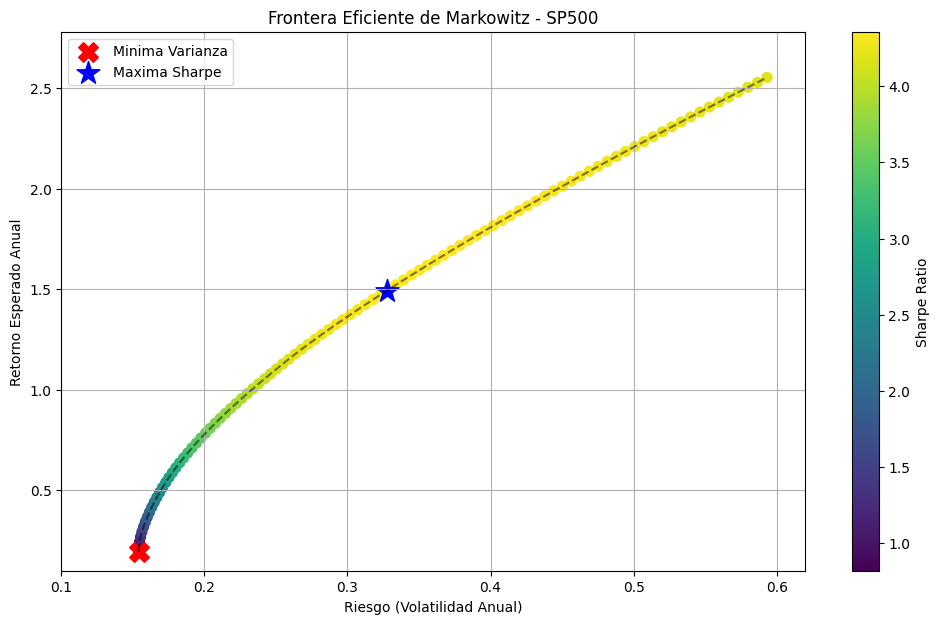

In [ ]:
# 10. Graficamos frontera eficiente
plt.figure(figsize=(12, 7)) #Definimos pulgadas (tamaño)

sc = plt.scatter(frontier_risks, frontier_returns, c=frontier_sharpes, cmap='viridis', s=50) #creamos nuestro gráfico de dispersión (scatter plot)
plt.plot(frontier_risks, frontier_returns, 'k--', alpha=0.5) #Dibujamos una línea que conecta todos los puntos de la frontera eficiente
plt.colorbar(sc, label='Sharpe Ratio') #Agregamos una barra de colores al gráfico, que indica el rango de los valores del ratio de Sharpe.

# Marcamos portafolios clave
plt.scatter(vol_min, ret_min, marker='X', color='red', s=200, label='Minima Varianza')
plt.scatter(vol_sharpe, ret_sharpe, marker='*', color='blue', s=300, label='Maxima Sharpe')

plt.title('Frontera Eficiente de Markowitz - SP500')
plt.xlabel('Riesgo (Volatilidad Anual)')
plt.ylabel('Retorno Esperado Anual')
plt.legend() #Mostramos la leyenda del gráfico, que ayuda a identificar qué representan los puntos y las líneas
plt.grid(True) #Activamos la cuadrícula en el gráfico para facilitar la visualización de los valores.
plt.xlim(0.1, .62)
plt.ylim(0.10, 2.78)
plt.show()


#Mostramos la frontera eficiente con color según el ratio de Sharpe.
#Señalamos los portafolios de mínima varianza y máxima Sharpe.
#Personalizamos los ejes y colores para mejor interpretación.

In [ ]:
#11 Opcional (grafico dinámico)
import plotly.express as px #Librería de alto nivel para crear gráficos rápidamente
import plotly.graph_objects as go #Permite mayor personalización (como agregar puntos especiales o modificar detalles).

#Creamos DataFrame para Plotly
df_plotly = df_completo.copy()
#Crea una copia de df_completo, que contiene:
##Retorno, riesgo, Sharpe Ratio

# Gráfico interactivo
fig = px.scatter(
    df_plotly,
    x="Riesgo (Volatilidad)",
    y="Retorno Esperado",
    color="Sharpe Ratio",
    hover_data=df_plotly.columns, #Al pasar el cursor sobre un punto del gráfico, se mostrarán todos los datos disponibles en ese renglón del DataFrame.
    title="Frontera Eficiente de Markowitz - IPSA",
    color_continuous_scale="viridis"
)
#Estamos creando un gráfico de dispersión donde:
##X = Riesgo (volatilidad).
##Y = Retorno esperado.
##Color = Sharpe Ratio (escala de colores continua).
##hover_data: Al pasar el mouse por un punto, muestra todos los datos del portafolio, incluyendo pesos por acción.
##title: Título del gráfico.
##amp: Paleta de colores (de bajo a alto valor de Sharpe).


# Añadimos portafolio mínima varianza
fig.add_trace(go.Scatter(
    x=[vol_min],
    y=[ret_min],
    mode='markers+text',
    #marker=dict(color='brown', size=15, symbol='x'),
    text=["Mínima Varianza"],
    textposition="top center",
    name='Mínima Varianza'
))
#Agregamos un punto azul con símbolo "X" en la ubicación del portafolio de mínima varianza.
#Se muestra con texto encima: “Mínima Varianza”.


# Añadimos portafolio máxima Sharpe
fig.add_trace(go.Scatter(
    x=[vol_sharpe],
    y=[ret_sharpe],
    mode='markers+text',
    #marker=dict(color='blue', size=15, symbol='star'),
    text=["Máxima Sharpe"],
    textposition="top center",
    name='Máxima Sharpe'
))
#Agregamos un punto rojo con forma de estrella en el portafolio de máxima Sharpe.
#También muestra texto encima.



fig.update_layout(
    xaxis_title='Riesgo (Volatilidad Anual)',
    yaxis_title='Retorno Esperado Anual',
    #legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    #coloraxis_colorbar=dict(title="Sharpe Ratio")
)
#Etiquetas de los ejes.
#Ubicación de la leyenda (arriba a la izquierda).
#Título del colorbar (leyenda de colores) → “Sharpe Ratio”.

fig.show()

In [ ]:
fig.write_html("frontera_eficiente_interactiva.html")

# Predictive Models

## NN

### trainer

In [ ]:

# Preparar variables predictoras (X) y variable objetivo (y)
X = df_frontera[['Riesgo (Volatilidad)', 'Retorno Esperado', 'Beta']] #Contiene las columnas que usaremos para predecir: riesgo, retorno y beta.
y = df_frontera['Sharpe Ratio'] #Variable objetivo que queremos predecir: el Sharpe Ratio.
#Intentamos predecir que tan eficiente es un portafolio (medido por el Sharpe) en función de su riesgo, retorno y sensibilidad al mercado (beta).

# Escalar características (estandarizar la información)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Red Neuronal Multicapa (MLP)
modelo = MLPRegressor(
    hidden_layer_sizes=(64, 32),  # Capas más profundas
    activation='relu', #función ReLU (Rectified Linear Unit)
    solver='adam', #optimizador que ajusta los pesos, eficiente y muy usado para redes neuronales.
    max_iter=2000, #máximo número de iteraciones (épocas) durante el entrenamiento.
    random_state=42,
    early_stopping=True, #detiene el entrenamiento si la validación no mejora.
    n_iter_no_change=20, #si durante 20 iteraciones no mejora, se detiene.
    validation_fraction=0.1, #usa el 10% de los datos de entrenamiento como conjunto de validación.
    verbose=True #imprime información durante el entrenamiento
)

# Entrenamiento, aquí comienza el entrenamiento real: la red ajusta sus pesos para predecir el Sharpe Ratio a partir de riesgo, retorno y beta.
modelo.fit(X_train, y_train)

# Predicción, usamos el modelo entrenado para predecir el Sharpe Ratio de los portafolios de prueba.
y_pred = modelo.predict(X_test)

# Evaluación
mse = mean_squared_error(y_test, y_pred) #Mide qué tan lejos están las predicciones del valor real. Valor cercano a 0 → mejor.
r2 = r2_score(y_test, y_pred) #Indica qué tanto varía y es explicado por X. 1.0 → modelo perfecto, 0.0 → no explica nada o Negativo → peor que una línea horizontal (la media).

print("\n🔍 MÉTRICAS DE DESEMPEÑO DEL MODELO")
print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.4f}")

Iteration 1, loss = 8.61864267
Validation score: -8.253882
Iteration 2, loss = 8.41315176
Validation score: -7.986873
Iteration 3, loss = 8.21456831
Validation score: -7.730892
Iteration 4, loss = 8.02294802
Validation score: -7.485545
Iteration 5, loss = 7.83628691
Validation score: -7.246581
Iteration 6, loss = 7.65549363
Validation score: -7.019645
Iteration 7, loss = 7.48186867
Validation score: -6.815187
Iteration 8, loss = 7.31905182
Validation score: -6.618264
Iteration 9, loss = 7.16187601
Validation score: -6.427437
Iteration 10, loss = 7.00951785
Validation score: -6.241760
Iteration 11, loss = 6.86087826
Validation score: -6.059350
Iteration 12, loss = 6.71594616
Validation score: -5.886344
Iteration 13, loss = 6.57380781
Validation score: -5.720930
Iteration 14, loss = 6.43513470
Validation score: -5.561883
Iteration 15, loss = 6.30128618
Validation score: -5.408512
Iteration 16, loss = 6.17606717
Validation score: -5.256105
Iteration 17, loss = 6.04998314
Validation score:

### error visualization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                            r2_score, explained_variance_score,
                            max_error, mean_absolute_percentage_error)
from scipy.stats import spearmanr

## 1. Cálculo de Métricas Completo
def calcular_metricas(y_real, y_pred):
    metrics = {
        'MSE': mean_squared_error(y_real, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_real, y_pred)),
        'MAE': mean_absolute_error(y_real, y_pred),
        'R²': r2_score(y_real, y_pred),
        'R² Ajustado': 1 - (1 - r2_score(y_real, y_pred)) * (len(y_real) - 1) / (len(y_real) - X_test.shape[1] - 1),
        'Varianza Explicada': explained_variance_score(y_real, y_pred),
        'Error Máximo': max_error(y_real, y_pred),
        'MAPE': mean_absolute_percentage_error(y_real, y_pred),
        'Correlación Spearman': spearmanr(y_real, y_pred)[0]
    }
    return metrics

metricas = calcular_metricas(y_test, y_pred)

## 2. Tabla de Resultados
def crear_tabla_metricas(metricas):
    df_metrics = pd.DataFrame.from_dict(metricas, orient='index', columns=['Valor'])
    df_metrics['Valor'] = df_metrics['Valor'].apply(lambda x: f"{x:.4f}")
    return df_metrics

tabla_metricas = crear_tabla_metricas(metricas)
print("\n📊 TABLA COMPLETA DE MÉTRICAS")
print(tabla_metricas)




📊 TABLA COMPLETA DE MÉTRICAS
                       Valor
MSE                   0.0332
RMSE                  0.1822
MAE                   0.1014
R²                    0.9690
R² Ajustado           0.9632
Varianza Explicada    0.9694
Error Máximo          0.6957
MAPE                  0.0672
Correlación Spearman  0.9624


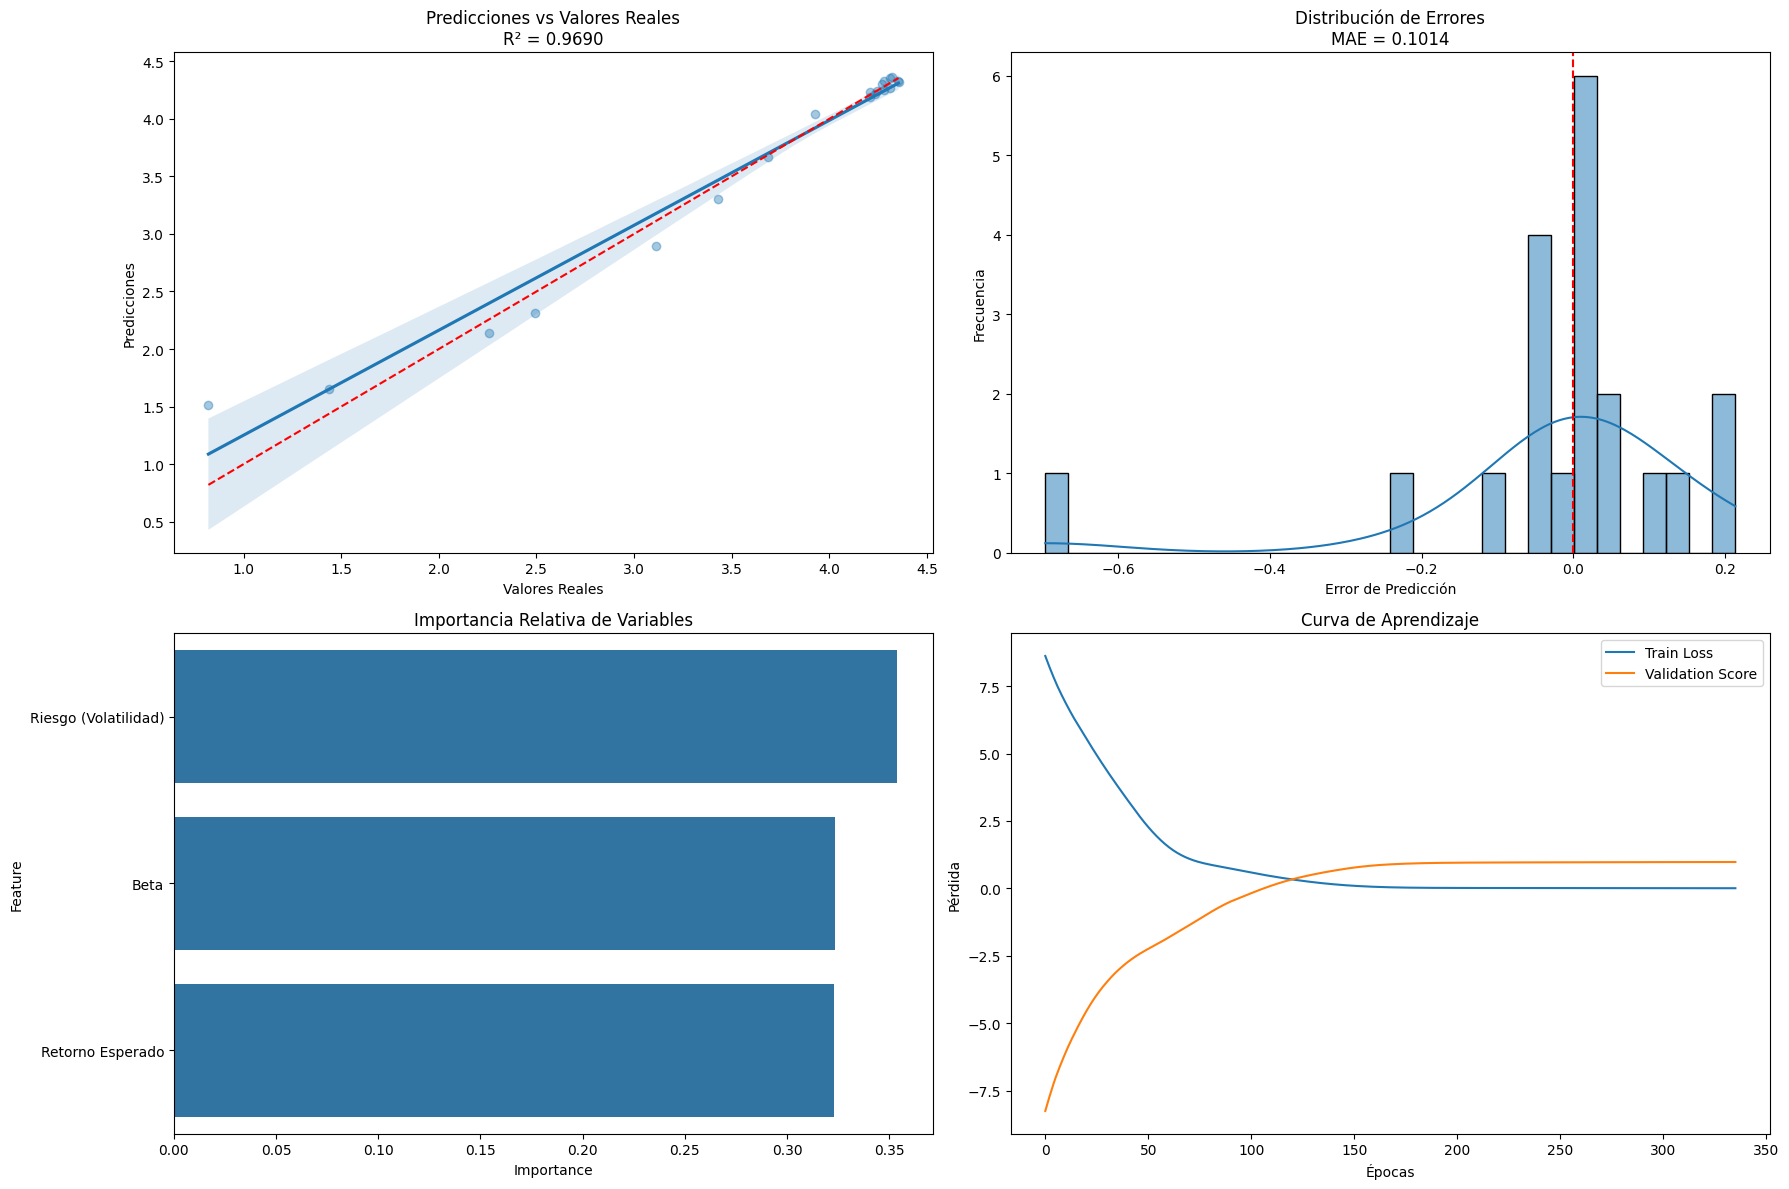


🔍 ANÁLISIS DETALLADO DE ERRORES
          Real Predicho    Error Error_Porcentual
count  20.0000  20.0000  20.0000          20.0000
mean    3.6267   3.6467  -0.0200          -4.0125
std     1.0617   0.9813   0.1858          19.5622
min     0.8193   1.5149  -0.6957         -84.9113
25%     3.3499   3.2038  -0.0393          -0.9104
50%     4.2205   4.2270   0.0118           0.2992
75%     4.2885   4.3069   0.0396           0.9112
max     4.3551   4.3606   0.2132           7.3622


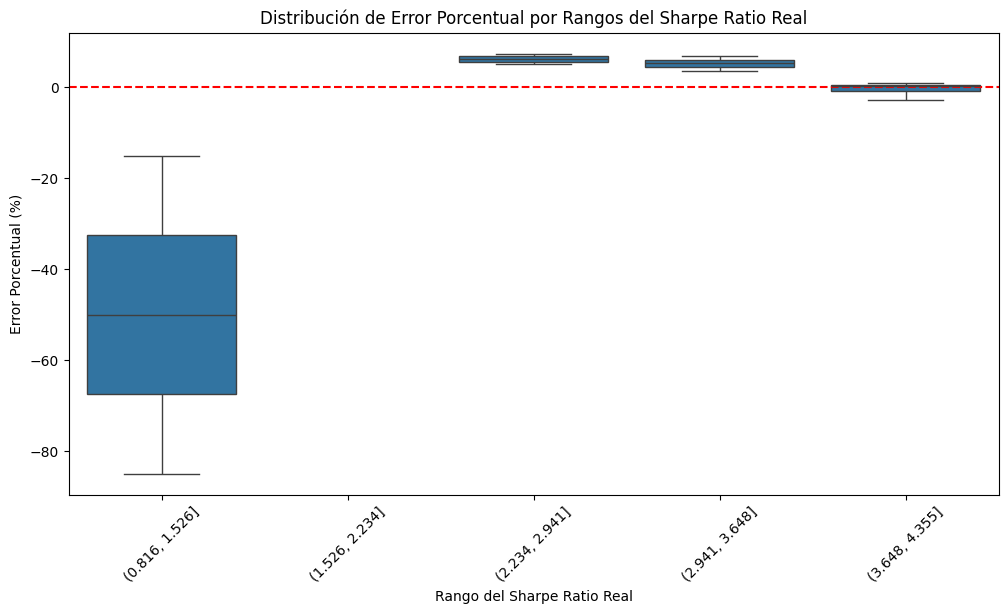

In [ ]:
## 3. Visualizaciones
plt.figure(figsize=(18, 12))

### Gráfico 1: Predicciones vs Valores Reales
plt.subplot(2, 2, 1)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales\nR² = {:.4f}'.format(metricas['R²']))

### Gráfico 2: Distribución de Errores
plt.subplot(2, 2, 2)
errors = y_test - y_pred
sns.histplot(errors, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores\nMAE = {:.4f}'.format(metricas['MAE']))

### Gráfico 3: Importancia de Variables (usando pesos de la red)
def plot_feature_importance(model, feature_names):
    # Para redes neuronales, aproximamos importancia por los pesos promedio
    weights = np.abs(model.coefs_[0]).mean(axis=1)
    importance = weights / weights.sum()
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feat_imp = feat_imp.sort_values('Importance', ascending=False)

    plt.subplot(2, 2, 3)
    sns.barplot(x='Importance', y='Feature', data=feat_imp)
    plt.title('Importancia Relativa de Variables')
    return feat_imp

feature_importance = plot_feature_importance(modelo, X.columns)

### Gráfico 4: Evolución del Error durante Entrenamiento
plt.subplot(2, 2, 4)
plt.plot(modelo.loss_curve_, label='Train Loss')
if hasattr(modelo, 'validation_scores_'):
    plt.plot(modelo.validation_scores_, label='Validation Score')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Aprendizaje')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Análisis de Errores Detallado
df_results = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred,
    'Error': y_test - y_pred,
    'Error_Porcentual': (y_test - y_pred) / y_test * 100
})

print("\n🔍 ANÁLISIS DETALLADO DE ERRORES")
print(df_results.describe().apply(lambda x: x.apply('{:.4f}'.format)))

## 5. Visualización de Errores por Rango
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(y_test, bins=5), y=df_results['Error_Porcentual'])
plt.xticks(rotation=45)
plt.title('Distribución de Error Porcentual por Rangos del Sharpe Ratio Real')
plt.ylabel('Error Porcentual (%)')
plt.xlabel('Rango del Sharpe Ratio Real')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but MLPRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/

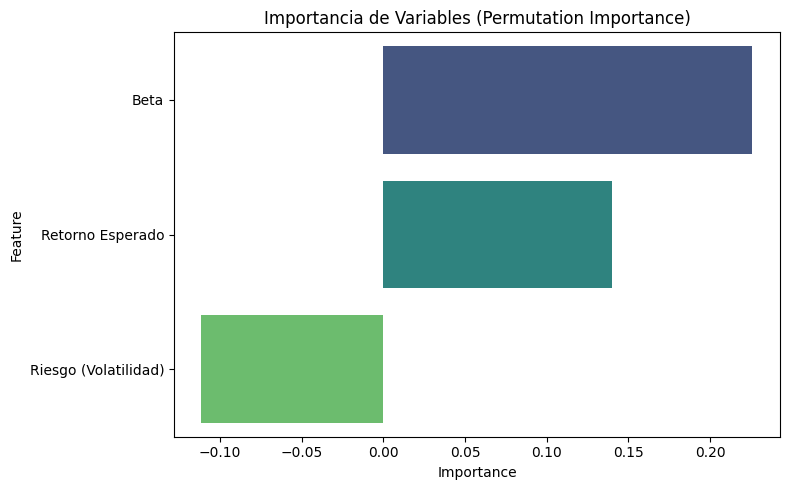

In [ ]:
from sklearn.inspection import permutation_importance

# Ya tienes un modelo entrenado
result = permutation_importance(modelo, X, y, n_repeats=30, random_state=42)

# Convertimos a DataFrame ordenado
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(8, 5))
sns.barplot(data=importances_df, y='Feature', x='Importance', palette='viridis')
plt.title('Importancia de Variables (Permutation Importance)')
plt.tight_layout()
plt.show()

In [ ]:
# Visualización de Bias², Varianza y MSE
plt.figure(figsize=(6,4))
labels = list(bias_var_result.keys())
values = list(bias_var_result.values())
sns.barplot(x=labels, y=values, palette='pastel')
plt.title("Descomposición del Error (Estimación)")
plt.ylabel("Valor")
plt.tight_layout()
plt.show()


NameError: name 'bias_var_result' is not defined

<Figure size 600x400 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

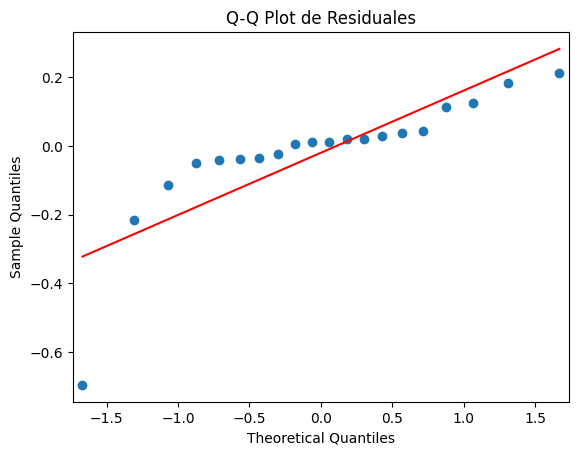

In [ ]:
from statsmodels.graphics.gofplots import qqplot

plt.figure(figsize=(12, 6))
qqplot(errors, line='s')
plt.title('Q-Q Plot de Residuales')
plt.show()

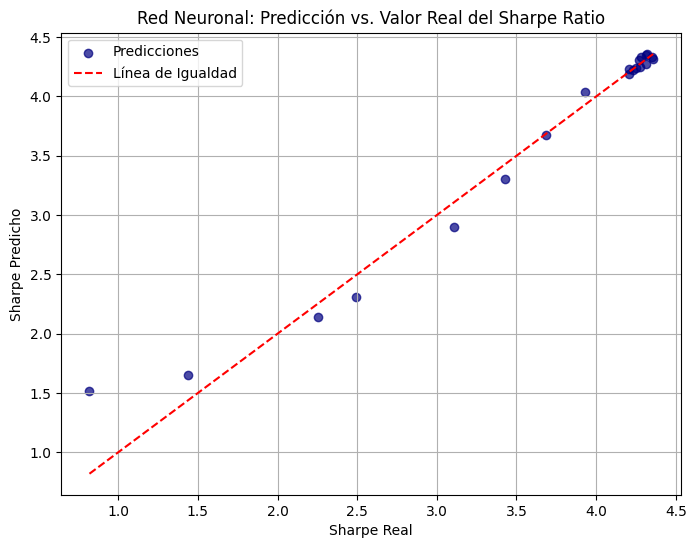

In [ ]:
#13 COMPARACIÓN VISUAL

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='navy', label='Predicciones')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Línea de Igualdad')
plt.title("Red Neuronal: Predicción vs. Valor Real del Sharpe Ratio")
plt.xlabel("Sharpe Real")
plt.ylabel("Sharpe Predicho")
plt.legend()
plt.grid(True)
plt.show()

### validation

In [ ]:
# Número de simulaciones (portafolios aleatorios)
n_simulaciones = 5000

# Lista de las acciones del sp500
acciones = returns_assets.columns.tolist()

# Matriz para guardar resultados
resultados = []

# Simular 5000 portafolios con pesos aleatorios
for _ in range(n_simulaciones):
    pesos = np.random.random(len(acciones))  # Pesos aleatorios
    pesos /= np.sum(pesos)  # Normalizar: suma total = 1

    # Calcular el retorno esperado, volatilidad y beta
    retorno_esperado = np.dot(pesos, returns_assets.mean()) * 252  # Anualizado
    matriz_cov = returns_assets.cov() * 252  # Anualizada
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov, pesos)))

    # Beta del portafolio
    beta_portafolio = np.dot(pesos, [betas[asset] for asset in acciones])

    # Guardarmos los resultados del portafolio
    resultados.append({
        'Pesos': pesos,
        'Acciones': acciones,
        'Retorno Esperado': retorno_esperado,
        'Riesgo (Volatilidad)': volatilidad,
        'Beta': beta_portafolio
    })

# Convertirmos los resultados a un DataFrame
df_simulaciones = pd.DataFrame(resultados)

# Extraemos X (variables predictoras para la red)
X_nuevos = df_simulaciones[['Riesgo (Volatilidad)', 'Retorno Esperado', 'Beta']]

# Escalamos las variables con el mismo scaler usado en el entrenamiento (o sea estandarizamos)
X_nuevos_scaled = scaler.transform(X_nuevos)

# Predecimos el Sharpe Ratio con la red neuronal
df_simulaciones['Sharpe Estimado'] = modelo.predict(X_nuevos_scaled)

# Ordenamos los resultados por el mejor Sharpe Ratio
df_mejores = df_simulaciones.sort_values(by='Sharpe Estimado', ascending=False)

# Mostramos los 5 mejores portafolios
print("Mejores portafolios según la red neuronal:")
print(df_mejores.head())

# Creamos una nueva columna con la composición del portafolio (acciones y pesos)
df_mejores['Composición del Portafolio'] = df_mejores.apply(lambda row: dict(zip(row['Acciones'], row['Pesos'])), axis=1)

# Guardamos la composición de los mejores portafolios en un archivo Excel
df_mejores[['Composición del Portafolio', 'Retorno Esperado', 'Riesgo (Volatilidad)', 'Beta', 'Sharpe Estimado']].to_excel('mejores_portafolios_composicion.xlsx', index=False)

print("Composición de los mejores portafolios guardada en 'mejores_portafolios_composicion.xlsx'")

Mejores portafolios según la red neuronal:
                                                  Pesos  \
2930  [0.0002676241442601932, 6.53563540404927e-05, ...   
1546  [0.0011940166583876233, 0.0023513638542234584,...   
2816  [0.002283788935516823, 0.001668179576779099, 0...   
1681  [0.0005744643484042921, 0.0023276654444396093,...   
242   [0.0009360152470470669, 0.0019745306037712396,...   

                                               Acciones  Retorno Esperado  \
2930  [DTE, CINF, GLW, VLO, PARA, FANG, D, MMC, J, D...          0.274431   
1546  [DTE, CINF, GLW, VLO, PARA, FANG, D, MMC, J, D...          0.274437   
2816  [DTE, CINF, GLW, VLO, PARA, FANG, D, MMC, J, D...          0.283899   
1681  [DTE, CINF, GLW, VLO, PARA, FANG, D, MMC, J, D...          0.269457   
242   [DTE, CINF, GLW, VLO, PARA, FANG, D, MMC, J, D...          0.273638   

      Riesgo (Volatilidad)      Beta  Sharpe Estimado  
2930              0.296277  1.077567         8.585129  
1546              0.294187 

In [ ]:
df_mejores.head(1)

,Pesos,Acciones,Retorno Esperado,Riesgo (Volatilidad),Beta,Sharpe Estimado,Composición del Portafolio
2930,"[0.0002676241442601932, 6.53563540404927e-05, ...","[DTE, CINF, GLW, VLO, PARA, FANG, D, MMC, J, D...",0.274431,0.296277,1.077567,8.585129,"{'DTE': 0.0002676241442601932, 'CINF': 6.53563..."


In [ ]:
df_mejores.shape

(5000, 7)

In [ ]:
df_mejores.iloc[0,6]

{'DTE': np.float64(0.0002676241442601932),
 'CINF': np.float64(6.53563540404927e-05),
 'GLW': np.float64(0.00021489385754232447),
 'VLO': np.float64(0.0030873928500882585),
 'PARA': np.float64(0.002962916074073604),
 'FANG': np.float64(0.003527962878536997),
 'D': np.float64(0.001397953610545253),
 'MMC': np.float64(0.0005439705432204494),
 'J': np.float64(0.0017037372849258256),
 'DAL': np.float64(0.0018649142953527551),
 'JBHT': np.float64(0.0036433089944311473),
 'TDG': np.float64(0.0018918105013504157),
 'HON': np.float64(0.0005619043144349583),
 'PCG': np.float64(0.002074434697748599),
 'RMD': np.float64(0.0007335472914891336),
 'NSC': np.float64(0.0035529367460954953),
 'ROL': np.float64(0.00016510090974786447),
 'UPS': np.float64(0.0036330065231715194),
 'KMX': np.float64(0.0008059898841169799),
 'ADI': np.float64(6.843841499546066e-05),
 'HST': np.float64(0.0005500566779410925),
 'AMCR': np.float64(0.002388323411123187),
 'ALGN': np.float64(0.003724357323311018),
 'DUK': np.flo

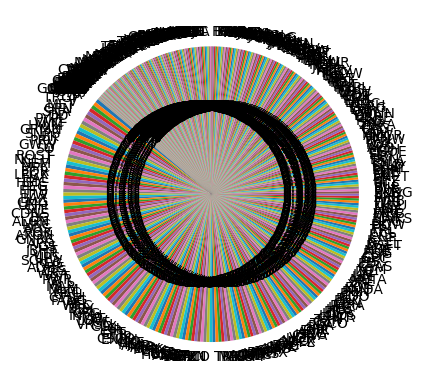

In [ ]:
for p in range(1):
  pesos = df_mejores.iloc[p,6]
  #print(type(pesos))
  d_o = sorted(pesos.items(), key=lambda item: item[1], reverse=True)
  #print(d_o)
  labels = [item[0] for item in d_o] # Extracts the first element of each tuple (the key/label)
  sizes = [item[1] for item in d_o]
  plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

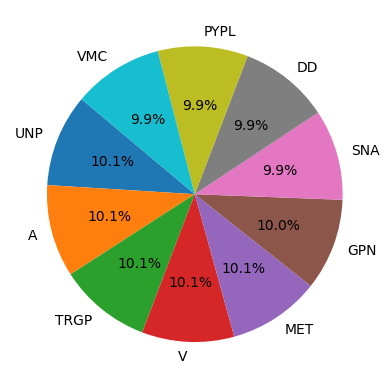

In [ ]:
for p in range(1):
  pesos = df_mejores.iloc[p,6]
  #print(type(pesos))
  d_o = sorted(pesos.items(), key=lambda item: item[1], reverse=True)
  #print(d_o)
  labels = [item[0] for item in d_o] # Extracts the first element of each tuple (the key/label)
  sizes = [item[1] for item in d_o]
  plt.pie(sizes[:10], labels=labels[:10], autopct='%1.1f%%', startangle=140)



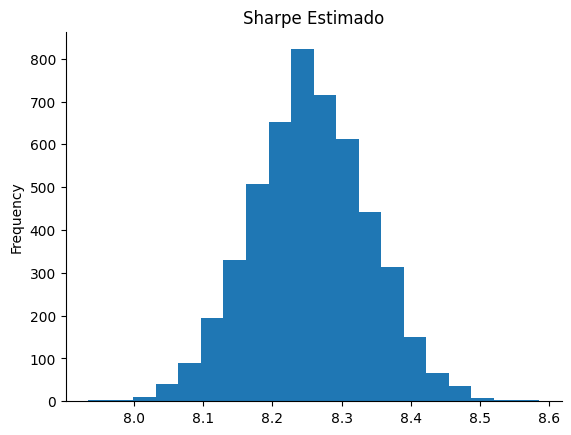

In [ ]:
# @title Sharpe Estimado

from matplotlib import pyplot as plt
df_mejores['Sharpe Estimado'].plot(kind='hist', bins=20, title='Sharpe Estimado')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Create the histogram using plotly.express
fig = px.histogram(df_mejores, x='Sharpe Estimado',
                   nbins=20, # Corresponds to 'bins' in matplotlib
                   title='Sharpe Estimado')

# To hide top and right spines (border lines), you can adjust the layout
fig.update_layout(
    xaxis_title_text='Sharpe Estimado', # Label for the x-axis
    yaxis_title_text='Frecuencia', # Label for the y-axis
    showlegend=False, # Histograms usually don't need a legend unless multiple traces
    # Remove plot borders (similar to spines)
    #xaxis=dict(showline=False), # Hide x-axis line
    #yaxis=dict(showline=False)  # Hide y-axis line
)

# You can also control the grid lines if desired
fig.update_xaxes(showgrid=True, gridcolor='lightgrey', zeroline=False)
fig.update_yaxes(showgrid=True, gridcolor='lightgrey', zeroline=False)

fig.show()

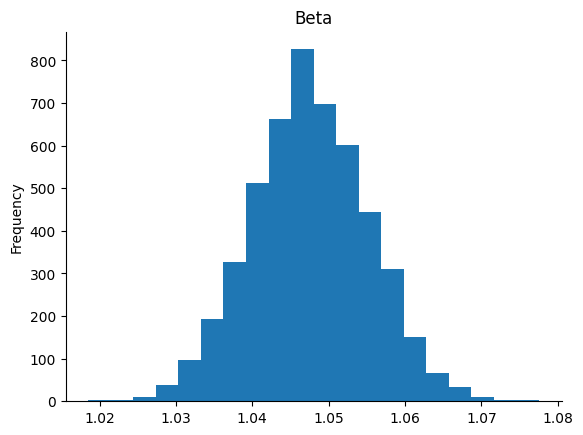

In [ ]:
# @title Beta

from matplotlib import pyplot as plt
df_mejores['Beta'].plot(kind='hist', bins=20, title='Beta')
plt.gca().spines[['top', 'right',]].set_visible(False)

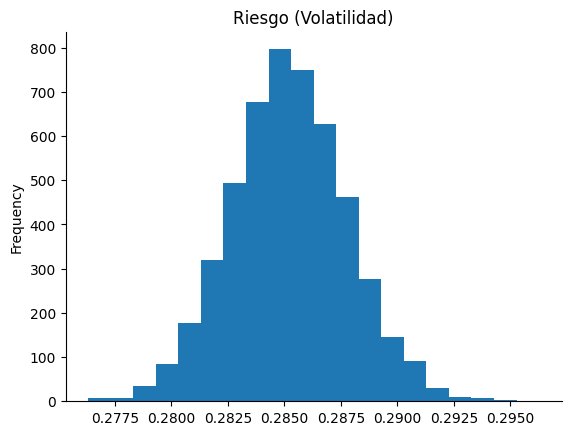

In [ ]:
# @title Riesgo (Volatilidad)

from matplotlib import pyplot as plt
df_mejores['Riesgo (Volatilidad)'].plot(kind='hist', bins=20, title='Riesgo (Volatilidad)')
plt.gca().spines[['top', 'right',]].set_visible(False)

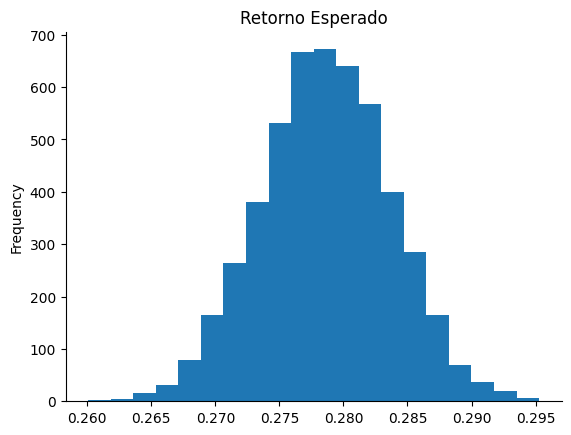

In [ ]:
# @title Retorno Esperado

from matplotlib import pyplot as plt
df_mejores['Retorno Esperado'].plot(kind='hist', bins=20, title='Retorno Esperado')
plt.gca().spines[['top', 'right',]].set_visible(False)

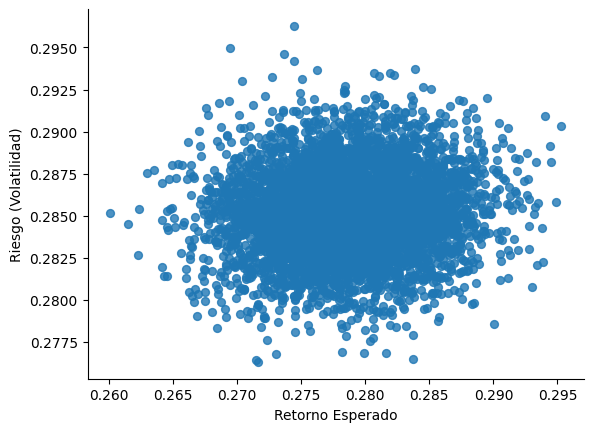

In [ ]:
# @title Retorno Esperado vs Riesgo (Volatilidad)

from matplotlib import pyplot as plt
df_mejores.plot(kind='scatter', x='Retorno Esperado', y='Riesgo (Volatilidad)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

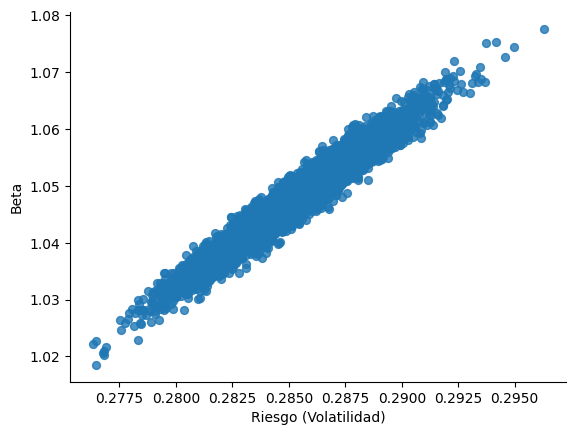

In [ ]:
# @title Riesgo (Volatilidad) vs Beta

from matplotlib import pyplot as plt
df_mejores.plot(kind='scatter', x='Riesgo (Volatilidad)', y='Beta', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

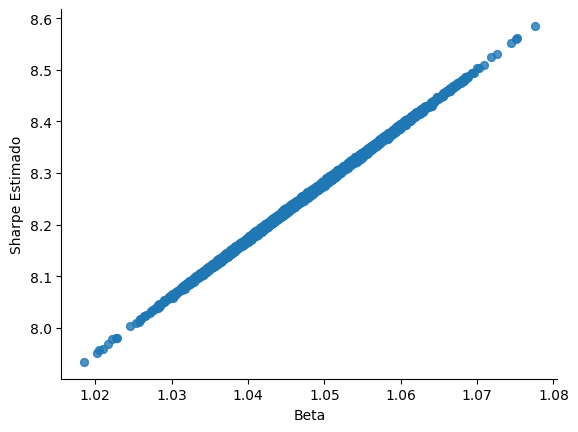

In [ ]:
# @title Beta vs Sharpe Estimado

from matplotlib import pyplot as plt
df_mejores.plot(kind='scatter', x='Beta', y='Sharpe Estimado', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# random forest

{'Bias²': np.float64(0.0330573276284323),
 'Varianza': np.float64(0.04390248210420611),
 'MSE estimado': 0.0330573276284323}

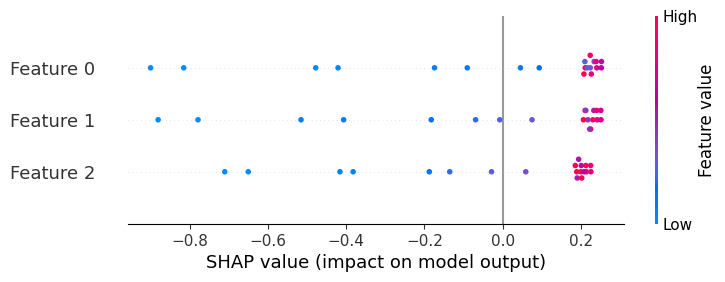

In [ ]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Usamos un RandomForest para demostrar SHAP (puedes reemplazarlo por tu modelo)
X = X_test.copy()
y = y_test.copy()

# Entrenamiento para SHAP
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 1. Descomposición del error MSE en Bias² + Varianza + Ruido
# En práctica, usamos métodos de validación cruzada para estimar estos componentes

from sklearn.utils import resample

def bias_variance_decomp(model, X, y, n_iter=50):
    preds = []
    for _ in range(n_iter):
        X_boot, y_boot = resample(X, y)
        model.fit(X_boot, y_boot)
        preds.append(model.predict(X))

    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)

    bias2 = ((y - mean_preds) ** 2).mean()
    variance = preds.var(axis=0).mean()
    mse_total = mean_squared_error(y, mean_preds)

    return {'Bias²': bias2, 'Varianza': variance, 'MSE estimado': mse_total}

bias_var_result = bias_variance_decomp(RandomForestRegressor(n_estimators=100, random_state=42), X, y)

# 2. Cálculo de SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Mostrar gráfico de summary
shap_summary_plot = shap.plots.beeswarm(shap_values, show=False)

bias_var_result


### debugging

In [ ]:
returns_assets = d1.pct_change().dropna()
returns_market = d2.pct_change().dropna()

# Alinear fechas entre activos e índice de mercado
#combined = returns_assets.join(returns_market, how='inner')

In [ ]:
print(returns_assets.shape)
print(returns_market.shape)

(503, 487)
(503, 1)


In [ ]:
d2 = pd.read_csv(f"{pwd}/sp500-2.csv",usecols=[1,2], parse_dates=[0],index_col=[0])

In [ ]:
 dd= d2['price'].pct_change()
 dd.dropna()

,price
date,
2020-01-03,-0.007060
2020-01-06,0.003533
2020-01-07,-0.002803
2020-01-08,0.004902
2020-01-09,0.006655
...,...
2021-12-23,0.006224
2021-12-27,0.013839
2021-12-28,-0.001010


In [ ]:
dd.shape

(504,)